In [1]:
!pip install tf-levenberg-marquardt

/tmp/ipykernel_4540/1083013530.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


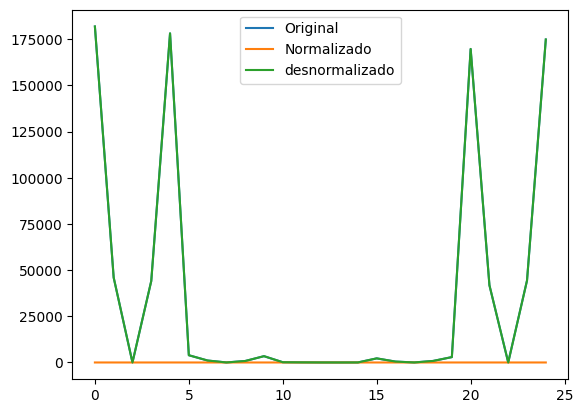

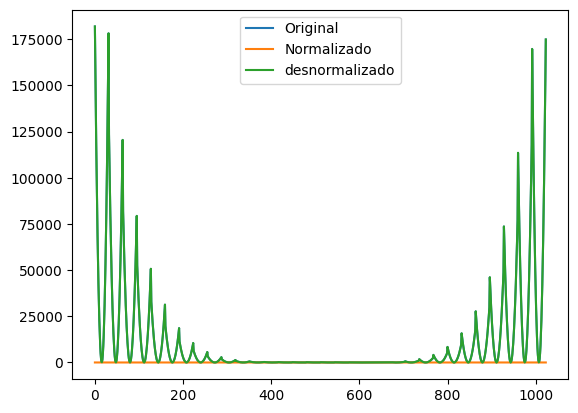

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def function(grid):
    x = np.linspace(-4.5, 4.5, grid)
    y = np.linspace(-4.5, 4.5, grid)
    x, y = np.meshgrid(x, y)
    z=(1.5 - x + x * y)**2 + (2.25 - x + x * y**2)**2+(2.625 - x + x * y**3)**2
    return x, y, z

def create_dataframe(grid):
   x, y, z = function(grid)
   data = {'X': x.flatten(), 'Y': y.flatten(), 'Z': z.flatten()}
   df = pd.DataFrame(data)
   return df

def show_norm(df, label="function", plot=False):
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["Z"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()


df_25 = create_dataframe(grid=5)
df_25_norm = show_norm(df_25)
test_out_scaler(df_25)

df_1000 = create_dataframe(grid=32)
df_1000_norm = show_norm(df_1000)
test_out_scaler(df_1000)



In [3]:
def split_df(df):
    _input = np.vstack([df['X'], df['Y']]).T
    _output = np.array(df['Z'])
    return (_input, _output)

In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import tf_levenberg_marquardt as lm


# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=lm.loss.MeanSquaredError())

        self.lm_model = lm.model.ModelWrapper(
            tf.keras.models.clone_model(self.model))
  

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.loss.MeanSquaredError())
        return(self.lm_model)


2025-01-24 22:14:46.115265: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-24 22:14:46.118316: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-24 22:14:46.125967: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737756886.140717    4540 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737756886.144938    4540 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-24 22:14:46.161050: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [5]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output, sup_input, sup_output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(sup_input, sup_output)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
      self._sup = (sup_input, sup_output)

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          vt_pred = self.lm_model.predict(self.vt_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))    
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_vt = r2_score(vt_denorm,  vt_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'r2_vt': r2_vt,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mse_vt': mse_vt,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [6]:
import pickle
from itertools import product

class Tester:
  def __init__(self, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input_25, self.output_25 = split_df(df_25_norm)
    self.input_1000, self.output_1000 = split_df(df_1000_norm)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

 
  def SaveModelWeights(self, model, fileName):
    if not fileName.endswith(".keras"):
        fileName += ".keras"
    path = f"content/models/{fileName}"
    open(path,'w').close()
    model.save(path)

  def SaveDataset(self, trainer, fileName):
    path = f"content/dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input_25, self.output_25, self.input_1000, self.output_1000)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'content/results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

In [7]:
import os
print(os.getcwd())

/workspaces/Ic-Rna-2024/fuction_ensemble_4/redes-ensemble-s/Teste01


# Treinando com 25 dados


In [8]:
tester = Tester(run_times=25, dataset_run_times=10)
tester.Loop(sort_by='r2',
            boundarie = 0.9, 
            hidden_sizes = [[5], [6], [7], [8], [9], [10], [11], [12], [13], [14]],
            regularizers=[0.2, 0.05],
            learning_rate=[0.01, 0.1])

Testando combinacao1: Hidden Size=[5], regularizer=0.2, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [1_0] | 5 +++++++

r2    r2_sup    r2_test    r2_val     r2_vt           mse  \
model_1_6_12  0.915556 -0.318691  -7.618995  0.772046  0.847162  5.581595e+07   
model_1_6_13  0.915379 -0.329698  -7.494116  0.770710  0.846296  5.593322e+07   
model_1_6_10  0.923552 -0.337007  -8.502586  0.803661  0.867996  5.053120e+07   
model_1_6_14  0.914947 -0.339161  -7.327084  0.768493  0.844854  5.621867e+07   
model_1_6_11  0.922971 -0.340843  -8.308163  0.800774  0.866113  5.091525e+07   
model_1_6_5   0.951813 -0.367120 -14.970513  0.931155  0.951508  3.185121e+07   
model_1_6_8   0.937484 -0.368827 -10.390710  0.859906  0.905007  4.132209e+07   
model_1_6_9   0.936383 -0.376358 -10.184068  0.854862  0.901694  4.205002e+07   
model_1_6_7   0.948442 -0.410631 -12.549118  0.907289  0.936087  3.407879e+07   
model_1_6_6   0.952290 -0.421045 -14.636269  0.931470  0.951776  3.153534e+07   
model_1_6_4   0.954115 -0.467054 -19.749650  0.963567  0.972192  3.032913e+07   
model_1_6_3   0.953336 -0.472227 -20.556784  0.966028  0.973685  3.084422e+07   
model_1_6_1   0.923510 -0.481415 -33.374989  0.940117  0.954246  5.055850e+07   
model_1_6_0   0.921344 -0.482518 -34.073347  0.937012  0.952063  5.199028e+07   
model_1_6_2   0.925615 -0.486513 -32.723572  0.943386  0.956530  4.916707e+07   

                   mse_sup      mse_test       mse_val        mse_vt  \
model_1_6_12  8.716352e+08  2.870874e+06  2.888739e+08  1.458724e+08   
model_1_6_13  8.789107e+08  2.829278e+06  2.905671e+08  1.466982e+08   
model_1_6_10  8.837420e+08  3.165186e+06  2.488096e+08  1.259874e+08   
model_1_6_14  8.851656e+08  2.773642e+06  2.933756e+08  1.480746e+08   
model_1_6_11  8.862777e+08  3.100427e+06  2.524686e+08  1.277845e+08   
model_1_6_5   9.036459e+08  5.319568e+06  8.724321e+07  4.628139e+07   
model_1_6_8   9.047746e+08  3.794096e+06  1.775335e+08  9.066378e+07   
model_1_6_9   9.097525e+08  3.725266e+06  1.839249e+08  9.382509e+07   
model_1_6_7   9.324063e+08  4.513033e+06  1.174870e+08  6.100003e+07   
model_1_6_6   9.392898e+08  5.208236e+06  8.684394e+07  4.602609e+07   
model_1_6_4   9.697013e+08  6.911436e+06  4.617009e+07  2.654076e+07   
model_1_6_3   9.731205e+08  7.180281e+06  4.305076e+07  2.511552e+07   
model_1_6_1   9.791935e+08  1.144986e+07  7.588671e+07  4.366828e+07   
model_1_6_0   9.799226e+08  1.168247e+07  7.982092e+07  4.575169e+07   
model_1_6_2   9.825633e+08  1.123288e+07  7.174379e+07  4.148834e+07   

                  mape         rmse    r2_adj          rsd       aic  \
model_1_6_12  0.570829  7471.007306  0.324451  7789.063555  6.324860   
model_1_6_13  0.569502  7478.851358  0.323032  7797.241544  6.320662   
model_1_6_10  0.585444  7108.529881  0.388414  7411.154715  6.523797   
model_1_6_14  0.566470  7497.911137  0.319577  7817.112737  6.310481   
model_1_6_11  0.582020  7135.492100  0.383765  7439.264772  6.508654   
model_1_6_5   0.674120  5643.688008  0.614500  5883.951490  7.446828   
model_1_6_8   0.612572  6428.226214  0.499873  6701.889112  6.926184   
model_1_6_9   0.610519  6484.598582  0.491063  6760.661369  6.891259   
model_1_6_7   0.638068  5837.704511  0.587539  6086.227677  7.311628   
model_1_6_6   0.668685  5615.633429  0.618323  5854.702571  7.466761   
model_1_6_4   0.731222  5507.189235  0.632922  5741.641682  7.544761   
model_1_6_3   0.741088  5553.757658  0.626688  5790.192620  7.511080   
model_1_6_1   0.904201  7110.450323  0.388083  7413.156914  6.522717   
model_1_6_0   0.912055  7210.428840  0.370754  7517.391723  6.466865   
model_1_6_2   0.896785  7011.923117  0.404924  7310.435201  6.578531   

                    bic  
model_1_6_12  31.921252  
model_1_6_13  31.917054  
model_1_6_10  32.120189  
model_1_6_14  31.906873  
model_1_6_11  32.105046  
model_1_6_5   33.043220  
model_1_6_8   32.522577  
model_1_6_9   32.487652  
model_1_6_7   32.908021  
model_1_6_6   33.063154  
model_1_6_4   33.141154  
model_1_6_3   33.107472  
model_1_6_1   32.119109  
model_1_6_0   32.063257  
model_1_6_2   32.174923

DataFrame salvo em content/results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Stopped at epoch:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_1_7_0   0.918499 -0.347694  0.941531  0.931138  0.936691  5.387072e+07   
model_1_7_1   0.920101 -0.362453  0.943388  0.928676  0.936533  5.281198e+07   
model_1_7_2   0.921651 -0.377209  0.945064  0.925939  0.936151  5.178738e+07   
model_1_7_3   0.923207 -0.391912  0.947410  0.924513  0.936738  5.075903e+07   
model_1_7_4   0.924704 -0.402681  0.947855  0.921388  0.935518  4.976957e+07   
model_1_7_7   0.939338 -0.405733  0.789732  0.572352  0.688375  4.009680e+07   
model_1_7_5   0.926040 -0.420168  0.944403  0.906597  0.926777  4.888669e+07   
model_1_7_8   0.940363 -0.423141  0.794482  0.563931  0.686981  3.941888e+07   
model_1_7_9   0.954316 -0.423768  0.713098  0.919901  0.809585  3.019622e+07   
model_1_7_6   0.927468 -0.436441  0.946690  0.903081  0.926358  4.794248e+07   
model_1_7_10  0.955154 -0.438543  0.718445  0.917255  0.811203  2.964259e+07   
model_1_7_11  0.956834 -0.471632  0.729787  0.912109  0.814854  2.853221e+07   
model_1_7_12  0.962702 -0.613724  0.773820  0.880001  0.823370  2.465329e+07   
model_1_7_13  0.967335 -0.731092  0.821922  0.859675  0.839552  2.159084e+07   
model_1_7_14  0.967798 -0.747017  0.822799  0.850782  0.835872  2.128512e+07   
model_1_7_15  0.968346 -0.764310  0.827693  0.844878  0.835729  2.092280e+07   
model_1_7_16  0.979279 -0.891581  0.962017  0.987174  0.973754  1.369658e+07   
model_1_7_17  0.979678 -0.911007  0.961802  0.989082  0.974530  1.343230e+07   
model_1_7_18  0.980065 -0.925984  0.961414  0.989762  0.974640  1.317701e+07   
model_1_7_20  0.981830 -0.927766  0.960189  0.979211  0.969065  1.200992e+07   
model_1_7_19  0.980418 -0.947237  0.960964  0.989438  0.974249  1.294311e+07   
model_1_7_21  0.982478 -0.957963  0.960772  0.975523  0.967657  1.158188e+07   
model_1_7_22  0.982767 -0.978163  0.961089  0.970423  0.965447  1.139084e+07   
model_1_7_23  0.983018 -0.995810  0.960765  0.962429  0.961546  1.122506e+07   
model_1_7_24  0.983155 -1.022488  0.960397  0.950223  0.955657  1.113424e+07   

                   mse_sup      mse_test       mse_val        mse_vt  \
model_1_7_0   8.908056e+08  3.402355e+06  3.503134e+06  3.452744e+06   
model_1_7_1   9.005611e+08  3.294283e+06  3.628409e+06  3.461346e+06   
model_1_7_2   9.103149e+08  3.196753e+06  3.767627e+06  3.482190e+06   
model_1_7_3   9.200333e+08  3.060234e+06  3.840147e+06  3.450190e+06   
model_1_7_4   9.271513e+08  3.034333e+06  3.999144e+06  3.516739e+06   
model_1_7_7   9.291688e+08  1.223556e+07  2.175523e+07  1.699539e+07   
model_1_7_5   9.387097e+08  3.235222e+06  4.751595e+06  3.993409e+06   
model_1_7_8   9.406753e+08  1.195917e+07  2.218366e+07  1.707142e+07   
model_1_7_9   9.410898e+08  1.669490e+07  4.074762e+06  1.038483e+07   
model_1_7_6   9.494660e+08  3.102129e+06  4.930454e+06  4.016291e+06   
model_1_7_10  9.508557e+08  1.638378e+07  4.209416e+06  1.029660e+07   
model_1_7_11  9.727269e+08  1.572379e+07  4.471185e+06  1.009749e+07   
model_1_7_12  1.066648e+09  1.316152e+07  6.104554e+06  9.633035e+06   
model_1_7_13  1.144226e+09  1.036242e+07  7.138612e+06  8.750516e+06   
model_1_7_14  1.154753e+09  1.031141e+07  7.591010e+06  8.951211e+06   
model_1_7_15  1.166183e+09  1.002662e+07  7.891358e+06  8.958988e+06   
model_1_7_16  1.250307e+09  2.210269e+06  6.524972e+05  1.431383e+06   
model_1_7_17  1.263147e+09  2.222733e+06  5.553995e+05  1.389066e+06   
model_1_7_18  1.273047e+09  2.245316e+06  5.208416e+05  1.383079e+06   
model_1_7_20  1.274225e+09  2.316624e+06  1.057587e+06  1.687106e+06   
model_1_7_19  1.287095e+09  2.271502e+06  5.372904e+05  1.404396e+06   
model_1_7_21  1.294185e+09  2.282672e+06  1.245183e+06  1.763928e+06   
model_1_7_22  1.307537e+09  2.264273e+06  1.504614e+06  1.884444e+06   
model_1_7_23  1.319201e+09  2.283100e+06  1.911304e+06  2.097202e+06   
model_1_7_24  1.336835e+09  2.304530e+06  2.532245e+06  2.418388e+06   

                  mape         rmse    r2_adj          rsd       a

DataFrame salvo em content/results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_1_8_0   0.968220 -0.791323  0.896959  0.992137  0.950822  2.100594e+07   
model_1_8_6   0.923920 -0.826376  0.693421  0.993961  0.861677  5.028745e+07   
model_1_8_3   0.937771 -0.899828  0.754899  0.994111  0.888926  4.113262e+07   
model_1_8_1   0.966301 -0.961569  0.882690  0.994591  0.945644  2.227453e+07   
model_1_8_4   0.942798 -1.020808  0.774452  0.995873  0.898383  3.780946e+07   
model_1_8_5   0.943308 -1.049486  0.775973  0.996179  0.899196  3.747266e+07   
model_1_8_2   0.960650 -1.073878  0.853801  0.995866  0.933460  2.600968e+07   
model_1_8_7   0.926038 -1.257170  0.696385  0.997824  0.864768  4.888781e+07   
model_1_8_8   0.921476 -1.276218  0.675299  0.998071  0.855560  5.190320e+07   
model_1_8_9   0.920276 -1.277215  0.670028  0.998037  0.853214  5.269618e+07   
model_1_8_10  0.909527 -1.302950  0.622448  0.997925  0.832127  5.980113e+07   

                   mse_sup      mse_test       mse_val        mse_vt  \
model_1_8_0   1.184038e+09  9.976339e+07  7.934590e+06  5.384899e+07   
model_1_8_6   1.207207e+09  2.968265e+08  6.094124e+06  1.514603e+08   
model_1_8_3   1.255758e+09  2.373042e+08  5.942922e+06  1.216236e+08   
model_1_8_1   1.296568e+09  1.135783e+08  5.458428e+06  5.951835e+07   
model_1_8_4   1.335724e+09  2.183732e+08  4.164006e+06  1.112686e+08   
model_1_8_5   1.354680e+09  2.169006e+08  3.855346e+06  1.103780e+08   
model_1_8_2   1.370802e+09  1.415483e+08  4.171209e+06  7.285973e+07   
model_1_8_7   1.491956e+09  2.939559e+08  2.196032e+06  1.480760e+08   
model_1_8_8   1.504546e+09  3.143712e+08  1.947023e+06  1.581591e+08   
model_1_8_9   1.505205e+09  3.194747e+08  1.980696e+06  1.607277e+08   
model_1_8_10  1.522216e+09  3.655414e+08  2.093963e+06  1.838177e+08   

                  mape         rmse    r2_adj          rsd       aic  \
model_1_8_0   0.273527  4583.223853  0.745762  4778.341181  8.279368   
model_1_8_6   0.199842  7091.364391  0.391364  7393.258454  6.533468   
model_1_8_3   0.218642  6413.471730  0.502166  6686.506499  6.935376   
model_1_8_1   0.243035  4719.589599  0.730408  4920.512299  8.162091   
model_1_8_4   0.214577  6148.939651  0.542387  6410.712742  7.103860   
model_1_8_5   0.213129  6121.491416  0.546463  6382.095979  7.121756   
model_1_8_2   0.225310  5099.968785  0.685201  5317.085015  7.852041   
model_1_8_7   0.180299  6991.982034  0.408304  7289.645185  6.589923   
model_1_8_8   0.178013  7204.387609  0.371808  7511.093305  6.470218   
model_1_8_9   0.176891  7259.213175  0.362211  7568.252908  6.439893   
model_1_8_10  0.163107  7733.118761  0.276218  8062.333636  6.186930   

                    bic  
model_1_8_0   33.875761  
model_1_8_6   32.129860  
model_1_8_3   32.531768  
model_1_8_1   33.758484  
model_1_8_4   32.700253  
model_1_8_5   32.718148  
model_1_8_2   33.448434  
model_1_8_7   32.186315  
model_1_8_8   32.066610  
model_1_8_9   32.036285  
model_1_8_10  31.783322

DataFrame salvo em content/results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_1_9_3   0.988627 -0.678249  0.988744  0.777373  0.977608  7.517144e+06   
model_1_9_5   0.992122 -0.811071  0.993830  0.794931  0.982995  5.207267e+06   
model_1_9_4   0.991724 -0.849927  0.993760  0.802740  0.983380  5.470603e+06   
model_1_9_6   0.991269 -0.855791  0.988933  0.803368  0.979252  5.771278e+06   
model_1_9_1   0.986566 -0.869764  0.990621  0.828622  0.982147  8.879936e+06   
model_1_9_2   0.986844 -0.877062  0.990905  0.830882  0.982520  8.696222e+06   
model_1_9_7   0.988834 -1.193608  0.968424  0.850545  0.964250  7.380283e+06   
model_1_9_8   0.982029 -1.293846  0.934198  0.855055  0.934984  1.187864e+07   
model_1_9_9   0.958355 -1.615426  0.818709  0.894602  0.837621  2.752647e+07   
model_1_9_10  0.958771 -1.646845  0.820706  0.893460  0.839278  2.725195e+07   
model_1_9_11  0.937786 -1.903255  0.720241  0.916963  0.753960  4.112265e+07   
model_1_9_0   0.915973 -1.930334  0.959717  0.961816  0.963078  5.554069e+07   
model_1_9_12  0.928585 -1.976812  0.676080  0.921482  0.716125  4.720420e+07   
model_1_9_16  0.928374 -2.006349  0.674814  0.921585  0.715040  4.734349e+07   
model_1_9_13  0.924111 -2.006581  0.654984  0.923087  0.698021  5.016120e+07   
model_1_9_14  0.921699 -2.026827  0.643549  0.924369  0.688231  5.175565e+07   
model_1_9_15  0.916772 -2.067842  0.620500  0.923724  0.668313  5.501274e+07   
model_1_9_17  0.919822 -2.160425  0.634058  0.925062  0.680083  5.299646e+07   
model_1_9_18  0.918829 -2.179591  0.629391  0.924978  0.676053  5.365313e+07   
model_1_9_19  0.921226 -2.182506  0.640503  0.925398  0.685661  5.206866e+07   
model_1_9_20  0.921550 -2.186114  0.641939  0.925567  0.686910  5.185397e+07   
model_1_9_21  0.910913 -2.247254  0.591794  0.928013  0.643796  5.888503e+07   
model_1_9_22  0.906132 -2.278848  0.569363  0.928592  0.624480  6.204513e+07   
model_1_9_23  0.904184 -2.294282  0.560134  0.929494  0.616572  6.333291e+07   
model_1_9_24  0.902828 -2.309509  0.553731  0.929688  0.611060  6.422928e+07   

                   mse_sup      mse_test       mse_val        mse_vt  \
model_1_9_3   1.109298e+09  9.947297e+06  1.299472e+07  1.147101e+07   
model_1_9_5   1.197091e+09  5.452444e+06  1.196989e+07  8.711167e+06   
model_1_9_4   1.222774e+09  5.514183e+06  1.151408e+07  8.514134e+06   
model_1_9_6   1.226650e+09  9.780043e+06  1.147741e+07  1.062873e+07   
model_1_9_1   1.235886e+09  8.288527e+06  1.000334e+07  9.145933e+06   
model_1_9_2   1.240710e+09  8.038139e+06  9.871418e+06  8.954779e+06   
model_1_9_7   1.449942e+09  2.790487e+07  8.723712e+06  1.831429e+07   
model_1_9_8   1.516198e+09  5.815255e+07  8.460459e+06  3.330650e+07   
model_1_9_9   1.728758e+09  1.602156e+08  6.152060e+06  8.318384e+07   
model_1_9_10  1.749526e+09  1.584514e+08  6.218709e+06  8.233507e+07   
model_1_9_11  1.919009e+09  2.472367e+08  4.846875e+06  1.260418e+08   
model_1_9_0   1.936907e+09  3.560030e+07  2.228775e+06  1.891454e+07   
model_1_9_12  1.967629e+09  2.862646e+08  4.583097e+06  1.454239e+08   
model_1_9_16  1.987152e+09  2.873828e+08  4.577087e+06  1.459800e+08   
model_1_9_13  1.987305e+09  3.049078e+08  4.489396e+06  1.546986e+08   
model_1_9_14  2.000688e+09  3.150132e+08  4.414602e+06  1.597139e+08   
model_1_9_15  2.027798e+09  3.353828e+08  4.452239e+06  1.699175e+08   
model_1_9_17  2.088994e+09  3.234011e+08  4.374110e+06  1.638876e+08   
model_1_9_18  2.101663e+09  3.275257e+08  4.379054e+06  1.659524e+08   
model_1_9_19  2.103590e+09  3.177057e+08  4.354518e+06  1.610301e+08   
model_1_9_20  2.105974e+09  3.164361e+08  4.344648e+06  1.603904e+08   
model_1_9_21  2.146387e+09  3.607520e+08  4.201868e+06  1.824769e+08   
model_1_9_22  2.167270e+09  3.805758e+08  4.168090e+06  1.923720e+08   
model_1_9_23  2.177472e+09  3.887315e+08  4.115405e+06  1.964234e+08   
model_1_9_24  2.187537e+09  3.943899e+08  4.104123e+06  1.992470e+08   

                  mape         rmse    r2_adj          rsd        

DataFrame salvo em content/results/metrics_1_9
Testando combinacao2: Hidden Size=[5], regularizer=0.2, learning_rate=0.1
+++++++++++ [2_0] | 1 ++++++++++++++++++


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [2_0] | 5 +++++++

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [3_0] | 5 +++++++

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [4_0] | 5 +++++++

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [5_0] | 5 +++++++

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [6_0] | 5 +++++++

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Stopped at epoch:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [7_0] | 5 ++++++

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [8_0] | 5 +++++++

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [9_0] | 5 +++++++

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Stopped at epoch:  8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Stopped at epoch:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [10_0] | 5 ++

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [11_0] | 2 ++++++++++++++++++
Stopped at epoch:  13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [11_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [11_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [11_0] | 5 ++

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
+++++++++++ [12_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [12_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [12_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [12_0] | 5 ++

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [13_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [13_0] | 3 ++++++++++++++++++
Stopped at epoch:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [13_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [13_0] | 5 +++

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [14_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [14_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [14_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [14_0] | 5 +++

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_14_4_0   0.903837  0.600448  0.896406  0.884993  0.893321  6.356241e+07   
model_14_4_1   0.916905  0.596048  0.924329  0.874374  0.900593  5.492467e+07   
model_14_4_2   0.926017  0.588716  0.945622  0.860198  0.903001  4.890181e+07   
model_14_4_3   0.931717  0.579191  0.961826  0.841910  0.900962  4.513399e+07   
model_14_4_4   0.934488  0.568082  0.973926  0.819470  0.894905  4.330241e+07   
model_14_4_5   0.934823  0.555997  0.982708  0.793339  0.885428  4.308088e+07   
model_14_4_6   0.933239  0.543522  0.988856  0.764393  0.873294  4.412790e+07   
model_14_4_7   0.930242  0.531147  0.992963  0.733725  0.859340  4.610910e+07   
model_14_4_8   0.926283  0.519222  0.995520  0.702412  0.844344  4.872572e+07   
model_14_4_9   0.921731  0.507955  0.996919  0.671350  0.828950  5.173465e+07   
model_14_4_10  0.916866  0.497450  0.997464  0.641198  0.813635  5.495002e+07   
model_14_4_11  0.911895  0.487739  0.997388  0.612400  0.798735  5.823627e+07   
model_14_4_12  0.906960  0.478816  0.996868  0.585228  0.784472  6.149793e+07   
model_14_4_13  0.902161  0.470650  0.996040  0.559819  0.770978  6.466991e+07   

                    mse_sup      mse_test       mse_val        mse_vt  \
model_14_4_0   2.640977e+08  8.069950e+07  1.012531e+08  9.097632e+07   
model_14_4_1   2.670064e+08  5.894771e+07  1.106014e+08  8.477455e+07   
model_14_4_2   2.718527e+08  4.236024e+07  1.230820e+08  8.272112e+07   
model_14_4_3   2.781485e+08  2.973758e+07  1.391833e+08  8.446042e+07   
model_14_4_4   2.854912e+08  2.031175e+07  1.589395e+08  8.962565e+07   
model_14_4_5   2.934794e+08  1.347057e+07  1.819450e+08  9.770778e+07   
model_14_4_6   3.017255e+08  8.681241e+06  2.074296e+08  1.080554e+08   
model_14_4_7   3.099049e+08  5.482157e+06  2.344302e+08  1.199562e+08   
model_14_4_8   3.177873e+08  3.490223e+06  2.619982e+08  1.327442e+08   
model_14_4_9   3.252345e+08  2.400298e+06  2.893455e+08  1.458729e+08   
model_14_4_10  3.321783e+08  1.975708e+06  3.158911e+08  1.589334e+08   
model_14_4_11  3.385967e+08  2.035017e+06  3.412446e+08  1.716398e+08   
model_14_4_12  3.444946e+08  2.439892e+06  3.651673e+08  1.838036e+08   
model_14_4_13  3.498924e+08  3.084983e+06  3.875377e+08  1.953114e+08   

                   mape         rmse    r2_adj          rsd        aic  \
model_14_4_0   1.229886  7972.603759  1.256435  8312.014007  30.064934   
model_14_4_1   1.181482  7411.118172  1.221587  7726.624815  30.357054   
model_14_4_2   1.138499  6992.982645  1.197289  7290.688393  30.589350   
model_14_4_3   1.101089  6718.183388  1.182088  7004.190364  30.749708   
model_14_4_4   1.069039  6580.456623  1.174698  6860.600285  30.832562   
model_14_4_5   1.041719  6563.602620  1.173805  6843.028772  30.842820   
model_14_4_6   1.018478  6642.883656  1.178029  6925.684966  30.794794   
model_14_4_7   0.998232  6790.368459  1.186022  7079.448502  30.706958   
model_14_4_8   0.980299  6980.380935  1.196578  7277.550203  30.596565   
model_14_4_9   0.964210  7192.680096  1.208717  7498.887379  30.476723   
model_14_4_10  0.955145  7412.828354  1.221689  7728.407804  30.356131   
model_14_4_11  0.960816  7631.268907  1.234947  7956.147823  30.239962   
model_14_4_12  0.966063  7842.061407  1.248106  8175.914196  30.130972   
model_14_4_13  0.970555  8041.760684  1.260903  8384.115085  30.030387   

                     bic  
model_14_4_0   70.287837  
model_14_4_1   70.579956  
model_14_4_2   70.812252  
model_14_4_3   70.972610  
model_14_4_4   71.055465  
model_14_4_5   71.065723  
model_14_4_6   71.017696  
model_14_4_7   70.929860  
model_14_4_8   70.819467  
model_14_4_9   70.699626  
model_14_4_10  70.579033  
model_14_4_11  70.462865  
model_14_4_12  70.353874  
model_14_4_13  70.253289

DataFrame salvo em content/results/metrics_14_4
+++++++++++ [14_5] | 1 ++++++++++++++++++
Stopped at epoch:  8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [14_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [14_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [14_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_14_6_15  0.920648  0.527652  0.623436  0.656332  0.684291  5.245075e+07   
model_14_6_16  0.919549  0.527651  0.622320  0.649846  0.678685  5.317717e+07   
model_14_6_17  0.918493  0.527602  0.620873  0.643841  0.673470  5.387521e+07   
model_14_6_14  0.921779  0.527590  0.624065  0.663317  0.690295  5.170280e+07   
model_14_6_18  0.917487  0.527516  0.619211  0.638293  0.668634  5.454020e+07   
model_14_6_13  0.922929  0.527446  0.624003  0.670822  0.696703  5.094274e+07   
model_14_6_19  0.916535  0.527404  0.617424  0.633179  0.664160  5.516935e+07   
model_14_6_20  0.915640  0.527274  0.615587  0.628474  0.660033  5.576090e+07   
model_14_6_12  0.924078  0.527199  0.622996  0.678861  0.703511  5.018323e+07   
model_14_6_21  0.914803  0.527132  0.613741  0.624154  0.656234  5.631417e+07   
model_14_6_22  0.914023  0.526984  0.611930  0.620194  0.652745  5.682947e+07   
model_14_6_23  0.913300  0.526834  0.610174  0.616570  0.649546  5.730757e+07   
model_14_6_11  0.925201  0.526824  0.620702  0.687447  0.710710  4.944108e+07   
model_14_6_24  0.912631  0.526684  0.608496  0.613258  0.646619  5.774968e+07   
model_14_6_10  0.926264  0.526292  0.616700  0.696586  0.718281  4.873823e+07   
model_14_6_9   0.927225  0.525568  0.610439  0.706280  0.726194  4.810291e+07   
model_14_6_8   0.928030  0.524613  0.601226  0.716525  0.734403  4.757097e+07   
model_14_6_7   0.928610  0.523382  0.588187  0.727306  0.742846  4.718780e+07   
model_14_6_6   0.928877  0.521824  0.570196  0.738601  0.751437  4.701099e+07   
model_14_6_5   0.928724  0.519878  0.545846  0.750378  0.760066  4.711259e+07   
model_14_6_4   0.928012  0.517481  0.513341  0.762590  0.768586  4.758289e+07   
model_14_6_3   0.926572  0.514556  0.470401  0.775178  0.776814  4.853504e+07   
model_14_6_2   0.924187  0.511020  0.414115  0.788065  0.784514  5.011120e+07   
model_14_6_1   0.920589  0.506773  0.340714  0.801163  0.791387  5.248948e+07   
model_14_6_0   0.915438  0.501703  0.245272  0.814372  0.797058  5.589454e+07   

                    mse_sup      mse_test       mse_val        mse_vt  \
model_14_6_15  3.122149e+08  2.255445e+07  2.990630e+08  1.608087e+08   
model_14_6_16  3.122154e+08  2.262129e+07  3.047071e+08  1.636642e+08   
model_14_6_17  3.122482e+08  2.270797e+07  3.099330e+08  1.663205e+08   
model_14_6_14  3.122562e+08  2.251682e+07  2.929841e+08  1.577505e+08   
model_14_6_18  3.123050e+08  2.280755e+07  3.147606e+08  1.687841e+08   
model_14_6_13  3.123515e+08  2.252052e+07  2.864534e+08  1.544869e+08   
model_14_6_19  3.123791e+08  2.291453e+07  3.192111e+08  1.710628e+08   
model_14_6_20  3.124651e+08  2.302461e+07  3.233052e+08  1.731649e+08   
model_14_6_12  3.125147e+08  2.258084e+07  2.794575e+08  1.510192e+08   
model_14_6_21  3.125587e+08  2.313517e+07  3.270646e+08  1.750999e+08   
model_14_6_22  3.126566e+08  2.324363e+07  3.305106e+08  1.768771e+08   
model_14_6_23  3.127559e+08  2.334880e+07  3.336639e+08  1.785064e+08   
model_14_6_11  3.127625e+08  2.271821e+07  2.719861e+08  1.473522e+08   
model_14_6_24  3.128546e+08  2.344933e+07  3.365459e+08  1.799976e+08   
model_14_6_10  3.131141e+08  2.295790e+07  2.640334e+08  1.434956e+08   
model_14_6_9   3.135925e+08  2.333294e+07  2.555974e+08  1.394651e+08   
model_14_6_8   3.142235e+08  2.388472e+07  2.466826e+08  1.352837e+08   
model_14_6_7   3.150372e+08  2.466573e+07  2.373008e+08  1.309833e+08   
model_14_6_6   3.160676e+08  2.574328e+07  2.274716e+08  1.266075e+08   
model_14_6_5   3.173533e+08  2.720178e+07  2.172231e+08  1.222125e+08   
model_14_6_4   3.189380e+08  2.914864e+07  2.065960e+08  1.178723e+08   
model_14_6_3   3.208711e+08  3.172054e+07  1.956421e+08  1.136813e+08   
model_14_6_2   3.232087e+08  3.509187e+07  1.844274e+08  1.097596e+08   
model_14_6_1   3.260154e+08  3.948822e+07  1.730296e+08  1.062589e+08   
model_14_6_0   3.293669e+08  4.520480e+07  1.615354e+08  1.033701e+08   

               

DataFrame salvo em content/results/metrics_14_6
+++++++++++ [14_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [14_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [14_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [14_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━

r2    r2_sup     r2_test    r2_val     r2_vt  \
model_14_7_3  0.905955  0.554423 -477.629083  0.839263  0.858399   
model_14_7_2  0.912644  0.553983 -413.700464  0.863549  0.878002   
model_14_7_1  0.916563  0.549535 -373.076985  0.894173  0.894181   
model_14_7_0  0.916789  0.540471 -359.163148  0.929268  0.905751   

                       mse       mse_sup      mse_test       mse_val  \
model_14_7_3  6.216205e+07  2.945198e+08  2.277025e+08  8.772143e+07   
model_14_7_2  5.774115e+07  2.948103e+08  1.972891e+08  7.446759e+07   
model_14_7_1  5.515078e+07  2.977504e+08  1.779630e+08  5.775454e+07   
model_14_7_0  5.500145e+07  3.037418e+08  1.713436e+08  3.860155e+07   

                    mse_vt      mape         rmse    r2_adj          rsd  \
model_14_7_3  1.577119e+08  1.101167  7884.291180  1.250785  8219.941779   
model_14_7_2  1.358784e+08  1.084203  7598.759925  1.232950  7922.254866   
model_14_7_1  1.178588e+08  1.079805  7426.356930  1.222499  7742.512319   
model_14_7_0  1.049726e+08  1.092429  7416.296565  1.221897  7732.023664   

                    aic        bic  
model_14_7_3  30.109490  70.332392  
model_14_7_2  30.257039  70.479941  
model_14_7_1  30.348837  70.571739  
model_14_7_0  30.354260  70.577162

DataFrame salvo em content/results/metrics_14_7
+++++++++++ [14_8] | 1 ++++++++++++++++++
Stopped at epoch:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [14_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [14_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [14_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [15_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [15_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [15_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [15_0] | 5 +++

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [16_0] | 2 ++++++++++++++++++
Stopped at epoch:  9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [16_0] | 3 ++++++++++++++++++
Stopped at epoch:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [16_0] | 4 ++++++++++++++++++
Stopped at epoch:  8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [16_0] | 5 +++

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [17_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [17_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [17_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [17_0] | 5 +++

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [18_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [18_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [18_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [18_0] | 5 +++

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [19_0] | 2 ++++++++++++++++++
Stopped at epoch:  9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [19_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [19_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [19_0] | 5 +++

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_0] | 2 ++++++++++++++++++
Stopped at epoch:  10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_0] | 3 ++++++++++++++++++
Stopped at epoch:  18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_0] | 5 +

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [21_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [21_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [21_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [21_0] | 5 +++

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [22_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [22_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [22_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [22_0] | 5 +++

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_22_4_0   0.901845  0.573615  0.980018 -1.765248  0.793116  6.487895e+07   
model_22_4_1   0.905062  0.568365  0.978035 -1.968867  0.777426  6.275231e+07   
model_22_4_2   0.907841  0.563467  0.976154 -2.124509  0.765107  6.091601e+07   
model_22_4_3   0.910149  0.558943  0.974337 -2.245474  0.755216  5.939009e+07   
model_22_4_4   0.911985  0.554753  0.972544 -2.342010  0.747016  5.817678e+07   
model_22_4_5   0.913378  0.550850  0.970756 -2.421281  0.740001  5.725614e+07   
model_22_4_6   0.914380  0.547199  0.968973 -2.488050  0.733846  5.659380e+07   
model_22_4_7   0.915052  0.543779  0.967207 -2.545438  0.728348  5.614925e+07   
model_22_4_8   0.915456  0.540577  0.965477 -2.595523  0.723380  5.588249e+07   
model_22_4_9   0.915646  0.537585  0.963796 -2.639707  0.718860  5.575660e+07   
model_22_4_10  0.915672  0.534798  0.962180 -2.678980  0.714733  5.573966e+07   
model_22_4_11  0.915574  0.532208  0.960639 -2.714055  0.710961  5.580452e+07   
model_22_4_12  0.915385  0.529809  0.959181 -2.745484  0.707511  5.592927e+07   
model_22_4_13  0.915133  0.527594  0.957809 -2.773716  0.704357  5.609603e+07   
model_22_4_14  0.914838  0.525554  0.956527 -2.799095  0.701478  5.629076e+07   
model_22_4_15  0.914518  0.523678  0.955333 -2.821924  0.698853  5.650225e+07   
model_22_4_16  0.914185  0.521959  0.954227 -2.842483  0.696461  5.672238e+07   

                    mse_sup      mse_test       mse_val        mse_vt  \
model_22_4_0   2.818341e+08  2.047233e+07  2.171633e+08  1.188178e+08   
model_22_4_1   2.853042e+08  2.250379e+07  2.331541e+08  1.278289e+08   
model_22_4_2   2.885419e+08  2.443059e+07  2.453771e+08  1.349037e+08   
model_22_4_3   2.915321e+08  2.629203e+07  2.548768e+08  1.405843e+08   
model_22_4_4   2.943014e+08  2.812933e+07  2.624581e+08  1.452937e+08   
model_22_4_5   2.968815e+08  2.996171e+07  2.686835e+08  1.493226e+08   
model_22_4_6   2.992948e+08  3.178824e+07  2.739271e+08  1.528577e+08   
model_22_4_7   3.015556e+08  3.359680e+07  2.784339e+08  1.560153e+08   
model_22_4_8   3.036720e+08  3.537008e+07  2.823673e+08  1.588685e+08   
model_22_4_9   3.056494e+08  3.709185e+07  2.858371e+08  1.614646e+08   
model_22_4_10  3.074919e+08  3.874753e+07  2.889213e+08  1.638343e+08   
model_22_4_11  3.092036e+08  4.032612e+07  2.916759e+08  1.660010e+08   
model_22_4_12  3.107891e+08  4.182041e+07  2.941441e+08  1.679823e+08   
model_22_4_13  3.122534e+08  4.322549e+07  2.963613e+08  1.697935e+08   
model_22_4_14  3.136021e+08  4.453964e+07  2.983543e+08  1.714471e+08   
model_22_4_15  3.148415e+08  4.576228e+07  3.001472e+08  1.729546e+08   
model_22_4_16  3.159778e+08  4.689567e+07  3.017617e+08  1.743286e+08   

                   mape         rmse    r2_adj          rsd        aic  \
model_22_4_0   0.767069  8054.747345  1.138572  8397.654615  46.023932   
model_22_4_1   0.754673  7921.635342  1.134029  8258.875759  46.090588   
model_22_4_2   0.739444  7804.870918  1.130107  8137.140432  46.149987   
model_22_4_3   0.722742  7706.496616  1.126848  8034.578131  46.200724   
model_22_4_4   0.705654  7627.370433  1.124257  7952.083383  46.242006   
model_22_4_5   0.688915  7566.778510  1.122290  7888.911937  46.273909   
model_22_4_6   0.672971  7522.884783  1.120876  7843.149563  46.297180   
model_22_4_7   0.658079  7493.280035  1.119926  7812.284479  46.312952   
model_22_4_8   0.644281  7475.459292  1.119357  7793.705070  46.322477   
model_22_4_9   0.631596  7467.033947  1.119088  7784.921041  46.326987   
model_22_4_10  0.619998  7465.900059  1.119052  7783.738881  46.327595   
model_22_4_11  0.609433  7470.242097  1.119190  7788.265768  46.325269   
model_22_4_12  0.599839  7478.587483  1.119456  7796.966435  46.320803   
model_22_4_13  0.591140  7489.728575  1.119813  7808.581827  46.314849   
model_22_4_14  0.583265  7502.717095  1.120229  7822.123295  46.307918   
model_22_4_15  0.576142  7516.797893  1.120680  7836.803541  46

DataFrame salvo em content/results/metrics_22_4
+++++++++++ [22_5] | 1 ++++++++++++++++++
Stopped at epoch:  16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [22_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [22_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [22_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_22_5_0   0.968798  0.586705  0.961865  0.181599  0.902963  2.062426e+07   
model_22_5_1   0.968713  0.586500  0.957835  0.141884  0.896338  2.068043e+07   
model_22_5_2   0.968446  0.586040  0.953896  0.106501  0.890128  2.085641e+07   
model_22_5_3   0.968055  0.585395  0.950100  0.075072  0.884351  2.111484e+07   
model_22_5_4   0.967583  0.584620  0.946483  0.047226  0.879010  2.142709e+07   
model_22_5_5   0.967062  0.583762  0.943070  0.022613  0.874098  2.177122e+07   
model_22_5_6   0.966518  0.582855  0.939872  0.000891  0.869600  2.213111e+07   
model_22_5_7   0.965968  0.581928  0.936894 -0.018252  0.865496  2.249465e+07   
model_22_5_8   0.965426  0.581002  0.934136 -0.035113  0.861762  2.285322e+07   
model_22_5_9   0.964900  0.580093  0.931592 -0.049961  0.858373  2.320084e+07   
model_22_5_10  0.964396  0.579213  0.929255 -0.063034  0.855303  2.353340e+07   
model_22_5_11  0.963920  0.578370  0.927115 -0.074546  0.852528  2.384822e+07   
model_22_5_12  0.963473  0.577571  0.925160 -0.084691  0.850021  2.414392e+07   
model_22_5_13  0.963055  0.576817  0.923377 -0.093644  0.847758  2.441988e+07   
model_22_5_14  0.962668  0.576112  0.921755 -0.101538  0.845719  2.467595e+07   
model_22_5_15  0.962310  0.575454  0.920282 -0.108520  0.843882  2.491270e+07   
model_22_5_16  0.961980  0.574844  0.918945 -0.114690  0.842227  2.513065e+07   
model_22_5_17  0.961677  0.574281  0.917734 -0.120154  0.840738  2.533073e+07   
model_22_5_18  0.961400  0.573762  0.916637 -0.124997  0.839397  2.551393e+07   
model_22_5_19  0.961147  0.573284  0.915645 -0.129295  0.838191  2.568136e+07   
model_22_5_20  0.960916  0.572847  0.914747 -0.133117  0.837106  2.583411e+07   
model_22_5_21  0.960705  0.572447  0.913937 -0.136509  0.836130  2.597309e+07   
model_22_5_22  0.960514  0.572082  0.913206 -0.139529  0.835252  2.609949e+07   
model_22_5_23  0.960341  0.571749  0.912545 -0.142220  0.834462  2.621433e+07   
model_22_5_24  0.960183  0.571446  0.911949 -0.144624  0.833752  2.631852e+07   

                    mse_sup      mse_test       mse_val        mse_vt  \
model_22_5_0   2.731819e+08  3.314209e+07  6.274160e+07  4.794185e+07   
model_22_5_1   2.733172e+08  3.664438e+07  6.578632e+07  5.121535e+07   
model_22_5_2   2.736213e+08  4.006764e+07  6.849893e+07  5.428329e+07   
model_22_5_3   2.740480e+08  4.336629e+07  7.090838e+07  5.713735e+07   
model_22_5_4   2.745600e+08  4.650923e+07  7.304316e+07  5.977619e+07   
model_22_5_5   2.751274e+08  4.947548e+07  7.493011e+07  6.220278e+07   
model_22_5_6   2.757268e+08  5.225510e+07  7.659534e+07  6.442527e+07   
model_22_5_7   2.763396e+08  5.484295e+07  7.806295e+07  6.645294e+07   
model_22_5_8   2.769517e+08  5.723976e+07  7.935559e+07  6.829762e+07   
model_22_5_9   2.775525e+08  5.945041e+07  8.049386e+07  6.997215e+07   
model_22_5_10  2.781340e+08  6.148160e+07  8.149606e+07  7.148886e+07   
model_22_5_11  2.786909e+08  6.334153e+07  8.237864e+07  7.286009e+07   
model_22_5_12  2.792194e+08  6.504083e+07  8.315642e+07  7.409862e+07   
model_22_5_13  2.797175e+08  6.658998e+07  8.384276e+07  7.521636e+07   
model_22_5_14  2.801838e+08  6.799966e+07  8.444797e+07  7.622381e+07   
model_22_5_15  2.806184e+08  6.928018e+07  8.498320e+07  7.713169e+07   
model_22_5_16  2.810216e+08  7.044198e+07  8.545619e+07  7.794909e+07   
model_22_5_17  2.813941e+08  7.149474e+07  8.587509e+07  7.868488e+07   
model_22_5_18  2.817373e+08  7.244794e+07  8.624637e+07  7.934716e+07   
model_22_5_19  2.820527e+08  7.331008e+07  8.657592e+07  7.994298e+07   
model_22_5_20  2.823417e+08  7.408981e+07  8.686887e+07  8.047937e+07   
model_22_5_21  2.826060e+08  7.479383e+07  8.712893e+07  8.096135e+07   
model_22_5_22  2.828474e+08  7.542973e+07  8.736050e+07  8.139511e+07   
model_22_5_23  2.830673e+08  7.600387e+07  8.756681e+07  8.178535e+07   
model_22_5_24  2.832676e+08  7.652209e+07  8.775109e+07  8.213657e+07   

               

DataFrame salvo em content/results/metrics_22_5
+++++++++++ [22_6] | 1 ++++++++++++++++++
Stopped at epoch:  9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [22_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [22_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [22_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━

r2    r2_sup     r2_test    r2_val     r2_vt  \
model_22_6_0  0.956661  0.598487 -161.208254  0.893118  0.891293   
model_22_6_1  0.949753  0.597630 -225.648607  0.861239  0.853915   
model_22_6_2  0.941909  0.595252 -292.199066  0.827743  0.814998   
model_22_6_3  0.933543  0.591815 -358.944940  0.793735  0.775740   
model_22_6_4  0.924956  0.587669 -424.545849  0.760001  0.736985   
model_22_6_5  0.916369  0.583079 -488.064712  0.727088  0.699324   
model_22_6_6  0.907940  0.578248 -548.862593  0.695376  0.663160   

                       mse       mse_sup      mse_test       mse_val  \
model_22_6_0  2.864645e+07  2.653939e+08  5.388855e+07  6.314916e+07   
model_22_6_1  3.321276e+07  2.659609e+08  7.529681e+07  8.198415e+07   
model_22_6_2  3.839748e+07  2.675325e+08  9.740609e+07  1.017744e+08   
model_22_6_3  4.392740e+07  2.698043e+08  1.195803e+08  1.218670e+08   
model_22_6_4  4.960315e+07  2.725449e+08  1.413741e+08  1.417984e+08   
model_22_6_5  5.527912e+07  2.755785e+08  1.624762e+08  1.612439e+08   
model_22_6_6  6.085007e+07  2.787718e+08  1.826744e+08  1.799806e+08   

                    mse_vt      mape         rmse    r2_adj          rsd  \
model_22_6_0  5.851889e+07  0.761610  5352.238281  1.061185  5580.094145   
model_22_6_1  7.864062e+07  0.800799  5763.051304  1.070937  6008.396329   
model_22_6_2  9.959028e+07  0.835925  6196.569840  1.082011  6460.370647   
model_22_6_3  1.207236e+08  0.871481  6627.774933  1.093822  6909.933033   
model_22_6_4  1.415862e+08  0.903526  7042.950363  1.105945  7342.783341   
model_22_6_5  1.618601e+08  0.932427  7434.993066  1.118068  7751.516114   
model_22_6_6  1.813276e+08  0.958496  7800.645226  1.129967  8132.734843   

                    aic        bic  
model_22_6_0  47.658920  97.632828  
model_22_6_1  47.363111  97.337019  
model_22_6_2  47.072995  97.046904  
model_22_6_3  46.803902  96.777811  
model_22_6_4  46.560870  96.534779  
model_22_6_5  46.344188  96.318097  
model_22_6_6  46.152153  96.126062

DataFrame salvo em content/results/metrics_22_6
+++++++++++ [22_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [22_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [22_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [22_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━

r2    r2_sup   r2_test      r2_val     r2_vt  \
model_22_7_0   0.910150  0.546223 -2.413345 -467.911178 -2.573489   
model_22_7_1   0.920637  0.546179 -2.119625 -425.172119 -2.262567   
model_22_7_2   0.929400  0.545149 -1.864027 -390.924811 -1.996217   
model_22_7_3   0.936681  0.543376 -1.643559 -364.345605 -1.770714   
model_22_7_4   0.942697  0.541056 -1.454974 -344.424954 -1.581853   
model_22_7_5   0.947641  0.538353 -1.294946 -330.093411 -1.425275   
model_22_7_6   0.951683  0.535398 -1.160207 -320.323219 -1.296729   
model_22_7_7   0.954968  0.532295 -1.047619 -314.183059 -1.192214   
model_22_7_8   0.957623  0.529130 -0.954227 -310.868226 -1.108066   
model_22_7_9   0.959757  0.525969 -0.877354 -309.701418 -1.041037   
model_22_7_10  0.961461  0.522862 -0.814533 -310.134733 -0.988246   
model_22_7_11  0.962812  0.519848 -0.763604 -311.721300 -0.947218   
model_22_7_12  0.963876  0.516955 -0.722641 -314.111704 -0.915814   
model_22_7_13  0.964705  0.514203 -0.689972 -317.039467 -0.892232   
model_22_7_14  0.965346  0.511603 -0.664163 -320.294086 -0.874948   
model_22_7_15  0.965834  0.509161 -0.643992 -323.718387 -0.862703   
model_22_7_16  0.966200  0.506881 -0.628419 -327.197241 -0.854443   
model_22_7_17  0.966470  0.504761 -0.616571 -330.647219 -0.849311   
model_22_7_18  0.966663  0.502797 -0.607723 -334.005532 -0.846597   
model_22_7_19  0.966795  0.500984 -0.601263 -337.232102 -0.845724   
model_22_7_20  0.966882  0.499316 -0.596712 -340.296739 -0.846242   

                        mse       mse_sup      mse_test       mse_val  \
model_22_7_0   5.938921e+07  2.999398e+08  2.124110e+08  4.914559e+07   
model_22_7_1   5.245771e+07  2.999687e+08  1.941329e+08  4.466620e+07   
model_22_7_2   4.666567e+07  3.006495e+08  1.782272e+08  4.107681e+07   
model_22_7_3   4.185296e+07  3.018220e+08  1.645075e+08  3.829110e+07   
model_22_7_4   3.787631e+07  3.033550e+08  1.527720e+08  3.620326e+07   
model_22_7_5   3.460827e+07  3.051416e+08  1.428135e+08  3.470120e+07   
model_22_7_6   3.193714e+07  3.070952e+08  1.344287e+08  3.367721e+07   
model_22_7_7   2.976572e+07  3.091459e+08  1.274224e+08  3.303367e+07   
model_22_7_8   2.801039e+07  3.112380e+08  1.216107e+08  3.268625e+07   
model_22_7_9   2.659995e+07  3.133277e+08  1.168269e+08  3.256396e+07   
model_22_7_10  2.547360e+07  3.153812e+08  1.129176e+08  3.260937e+07   
model_22_7_11  2.458046e+07  3.173732e+08  1.097483e+08  3.277566e+07   
model_22_7_12  2.387751e+07  3.192853e+08  1.071992e+08  3.302619e+07   
model_22_7_13  2.332926e+07  3.211047e+08  1.051662e+08  3.333304e+07   
model_22_7_14  2.290605e+07  3.228235e+08  1.035601e+08  3.367415e+07   
model_22_7_15  2.258333e+07  3.244371e+08  1.023049e+08  3.403305e+07   
model_22_7_16  2.234120e+07  3.259443e+08  1.013358e+08  3.439766e+07   
model_22_7_17  2.216306e+07  3.273457e+08  1.005985e+08  3.475924e+07   
model_22_7_18  2.203556e+07  3.286438e+08  1.000479e+08  3.511122e+07   
model_22_7_19  2.194771e+07  3.298419e+08  9.964591e+07  3.544939e+07   
model_22_7_20  2.189081e+07  3.309447e+08  9.936269e+07  3.577059e+07   

                     mse_vt      mape         rmse    r2_adj          rsd  \
model_22_7_0   1.307783e+08  0.922414  7706.439750  1.126846  8034.518844   
model_22_7_1   1.193996e+08  0.881976  7242.769363  1.112042  7551.109049   
model_22_7_2   1.096520e+08  0.844015  6831.227465  1.099671  7122.046961   
model_22_7_3   1.013993e+08  0.808544  6469.386528  1.089392  6744.801705   
model_22_7_4   9.448760e+07  0.775559  6154.373167  1.080898  6416.377574   
model_22_7_5   8.875735e+07  0.751443  5882.879700  1.073918  6133.326069   
model_22_7_6   8.405297e+07  0.744323  5651.295821  1.068213  5891.883184   
model_22_7_7   8.022805e+07  0.738362  5455.797323  1.063575  5688.061910   
model_22_7_8   7.714849e+07  0.736173  5292.484431  1.059826  5517.796450   
model_22_7_9   7.469544e+07  0.733883  5157.513607  1.056813  5377.079639   
model_22_7_10  7.276349e+07  0.731528  5047.1379

DataFrame salvo em content/results/metrics_22_7
+++++++++++ [22_8] | 1 ++++++++++++++++++
Stopped at epoch:  84
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [22_8] | 2 ++++++++++++++++++
Stopped at epoch:  8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [22_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [22_8] | 4 ++++++++++++++++++
Stopped at epoch:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_22_8_12  0.988983  0.551047  0.720166  0.971258  0.954292  7.282163e+06   
model_22_8_22  0.988983  0.551047  0.720166  0.971258  0.954292  7.282163e+06   
model_22_8_21  0.988983  0.551047  0.720166  0.971258  0.954292  7.282163e+06   
model_22_8_20  0.988983  0.551047  0.720166  0.971258  0.954292  7.282163e+06   
model_22_8_19  0.988983  0.551047  0.720166  0.971258  0.954292  7.282163e+06   
model_22_8_18  0.988983  0.551047  0.720166  0.971258  0.954292  7.282163e+06   
model_22_8_17  0.988983  0.551047  0.720166  0.971258  0.954292  7.282163e+06   
model_22_8_16  0.988983  0.551047  0.720166  0.971258  0.954292  7.282163e+06   
model_22_8_15  0.988983  0.551047  0.720166  0.971258  0.954292  7.282163e+06   
model_22_8_14  0.988983  0.551047  0.720166  0.971258  0.954292  7.282163e+06   
model_22_8_13  0.988983  0.551047  0.720166  0.971258  0.954292  7.282163e+06   
model_22_8_23  0.988983  0.551047  0.720166  0.971258  0.954292  7.282163e+06   
model_22_8_24  0.988983  0.551047  0.720166  0.971258  0.954292  7.282163e+06   
model_22_8_10  0.988983  0.551047  0.720166  0.971258  0.954292  7.282163e+06   
model_22_8_9   0.988983  0.551047  0.720166  0.971258  0.954292  7.282163e+06   
model_22_8_11  0.988983  0.551047  0.720166  0.971258  0.954292  7.282163e+06   
model_22_8_7   0.988983  0.551047  0.720169  0.971258  0.954292  7.282109e+06   
model_22_8_8   0.988983  0.551046  0.720167  0.971258  0.954292  7.282139e+06   
model_22_8_6   0.988983  0.551046  0.720178  0.971260  0.954294  7.281836e+06   
model_22_8_5   0.988985  0.551046  0.720213  0.971264  0.954300  7.280792e+06   
model_22_8_4   0.988985  0.551046  0.720217  0.971265  0.954301  7.280641e+06   
model_22_8_3   0.988985  0.551046  0.720225  0.971266  0.954303  7.280453e+06   
model_22_8_2   0.988986  0.551046  0.720243  0.971267  0.954305  7.279981e+06   
model_22_8_1   0.988987  0.551045  0.720250  0.971269  0.954307  7.279735e+06   
model_22_8_0   0.988988  0.551045  0.720282  0.971273  0.954313  7.278747e+06   

                    mse_sup      mse_test       mse_val        mse_vt  \
model_22_8_12  2.967516e+08  1.991547e+07  2.559802e+07  2.275672e+07   
model_22_8_22  2.967516e+08  1.991547e+07  2.559802e+07  2.275672e+07   
model_22_8_21  2.967516e+08  1.991547e+07  2.559802e+07  2.275672e+07   
model_22_8_20  2.967516e+08  1.991547e+07  2.559802e+07  2.275672e+07   
model_22_8_19  2.967516e+08  1.991547e+07  2.559802e+07  2.275672e+07   
model_22_8_18  2.967516e+08  1.991547e+07  2.559802e+07  2.275672e+07   
model_22_8_17  2.967516e+08  1.991547e+07  2.559802e+07  2.275672e+07   
model_22_8_16  2.967516e+08  1.991547e+07  2.559802e+07  2.275672e+07   
model_22_8_15  2.967516e+08  1.991547e+07  2.559802e+07  2.275672e+07   
model_22_8_14  2.967516e+08  1.991547e+07  2.559802e+07  2.275672e+07   
model_22_8_13  2.967516e+08  1.991547e+07  2.559802e+07  2.275672e+07   
model_22_8_23  2.967516e+08  1.991547e+07  2.559802e+07  2.275672e+07   
model_22_8_24  2.967516e+08  1.991547e+07  2.559802e+07  2.275672e+07   
model_22_8_10  2.967516e+08  1.991547e+07  2.559802e+07  2.275672e+07   
model_22_8_9   2.967516e+08  1.991547e+07  2.559802e+07  2.275672e+07   
model_22_8_11  2.967516e+08  1.991547e+07  2.559802e+07  2.275672e+07   
model_22_8_7   2.967516e+08  1.991526e+07  2.559791e+07  2.275656e+07   
model_22_8_8   2.967516e+08  1.991541e+07  2.559798e+07  2.275667e+07   
model_22_8_6   2.967518e+08  1.991464e+07  2.559683e+07  2.275571e+07   
model_22_8_5   2.967522e+08  1.991214e+07  2.559278e+07  2.275246e+07   
model_22_8_4   2.967522e+08  1.991184e+07  2.559220e+07  2.275202e+07   
model_22_8_3   2.967522e+08  1.991128e+07  2.559152e+07  2.275140e+07   
model_22_8_2   2.967523e+08  1.991002e+07  2.558978e+07  2.274991e+07   
model_22_8_1   2.967523e+08  1.990953e+07  2.558875e+07  2.274914e+07   
model_22_8_0   2.967525e+08  1.990726e+07  2.558486e+07  2.274609e+07   

               

DataFrame salvo em content/results/metrics_22_8
+++++++++++ [22_9] | 1 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [22_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [22_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [22_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━

r2    r2_sup   r2_test  r2_val     r2_vt           mse  \
model_22_9_0   0.988983  0.551047  0.963545     1.0  0.972123  7.282163e+06   
model_22_9_22  0.988983  0.551047  0.963545     1.0  0.972123  7.282163e+06   
model_22_9_21  0.988983  0.551047  0.963545     1.0  0.972123  7.282163e+06   
model_22_9_20  0.988983  0.551047  0.963545     1.0  0.972123  7.282163e+06   
model_22_9_19  0.988983  0.551047  0.963545     1.0  0.972123  7.282163e+06   
model_22_9_18  0.988983  0.551047  0.963545     1.0  0.972123  7.282163e+06   
model_22_9_17  0.988983  0.551047  0.963545     1.0  0.972123  7.282163e+06   
model_22_9_16  0.988983  0.551047  0.963545     1.0  0.972123  7.282163e+06   
model_22_9_15  0.988983  0.551047  0.963545     1.0  0.972123  7.282163e+06   
model_22_9_14  0.988983  0.551047  0.963545     1.0  0.972123  7.282163e+06   
model_22_9_13  0.988983  0.551047  0.963545     1.0  0.972123  7.282163e+06   
model_22_9_23  0.988983  0.551047  0.963545     1.0  0.972123  7.282163e+06   
model_22_9_12  0.988983  0.551047  0.963545     1.0  0.972123  7.282163e+06   
model_22_9_10  0.988983  0.551047  0.963545     1.0  0.972123  7.282163e+06   
model_22_9_9   0.988983  0.551047  0.963545     1.0  0.972123  7.282163e+06   
model_22_9_8   0.988983  0.551047  0.963545     1.0  0.972123  7.282163e+06   
model_22_9_7   0.988983  0.551047  0.963545     1.0  0.972123  7.282163e+06   
model_22_9_6   0.988983  0.551047  0.963545     1.0  0.972123  7.282163e+06   
model_22_9_5   0.988983  0.551047  0.963545     1.0  0.972123  7.282163e+06   
model_22_9_4   0.988983  0.551047  0.963545     1.0  0.972123  7.282163e+06   
model_22_9_3   0.988983  0.551047  0.963545     1.0  0.972123  7.282163e+06   
model_22_9_2   0.988983  0.551047  0.963545     1.0  0.972123  7.282163e+06   
model_22_9_1   0.988983  0.551047  0.963545     1.0  0.972123  7.282163e+06   
model_22_9_11  0.988983  0.551047  0.963545     1.0  0.972123  7.282163e+06   
model_22_9_24  0.988983  0.551047  0.963545     1.0  0.972123  7.282163e+06   

                    mse_sup      mse_test   mse_val        mse_vt      mape  \
model_22_9_0   2.967516e+08  2.846789e+07  0.001656  1.423394e+07  0.298307   
model_22_9_22  2.967516e+08  2.846789e+07  0.001656  1.423394e+07  0.298307   
model_22_9_21  2.967516e+08  2.846789e+07  0.001656  1.423394e+07  0.298307   
model_22_9_20  2.967516e+08  2.846789e+07  0.001656  1.423394e+07  0.298307   
model_22_9_19  2.967516e+08  2.846789e+07  0.001656  1.423394e+07  0.298307   
model_22_9_18  2.967516e+08  2.846789e+07  0.001656  1.423394e+07  0.298307   
model_22_9_17  2.967516e+08  2.846789e+07  0.001656  1.423394e+07  0.298307   
model_22_9_16  2.967516e+08  2.846789e+07  0.001656  1.423394e+07  0.298307   
model_22_9_15  2.967516e+08  2.846789e+07  0.001656  1.423394e+07  0.298307   
model_22_9_14  2.967516e+08  2.846789e+07  0.001656  1.423394e+07  0.298307   
model_22_9_13  2.967516e+08  2.846789e+07  0.001656  1.423394e+07  0.298307   
model_22_9_23  2.967516e+08  2.846789e+07  0.001656  1.423394e+07  0.298307   
model_22_9_12  2.967516e+08  2.846789e+07  0.001656  1.423394e+07  0.298307   
model_22_9_10  2.967516e+08  2.846789e+07  0.001656  1.423394e+07  0.298307   
model_22_9_9   2.967516e+08  2.846789e+07  0.001656  1.423394e+07  0.298307   
model_22_9_8   2.967516e+08  2.846789e+07  0.001656  1.423394e+07  0.298307   
model_22_9_7   2.967516e+08  2.846789e+07  0.001656  1.423394e+07  0.298307   
model_22_9_6   2.967516e+08  2.846789e+07  0.001656  1.423394e+07  0.298307   
model_22_9_5   2.967516e+08  2.846789e+07  0.001656  1.423394e+07  0.298307   
model_22_9_4   2.967516e+08  2.846789e+07  0.001656  1.423394e+07  0.298307   
model_22_9_3   2.967516e+08  2.846789e+07  0.001656  1.423394e+07  0.298307   
model_22_9_2   2.967516e+08  2.846789e+07  0.001656  1.423394e+07  0.298307   
model_22_9_1   2.967516e+08  2.846789e+07  0.001656  1.423394e+07  0.298307   
model_22_9_11  2.967516e+08  2.846789e+07  0.001656  1.423394e+07  0.2

DataFrame salvo em content/results/metrics_22_9
Testando combinacao23: Hidden Size=[10], regularizer=0.05, learning_rate=0.01
+++++++++++ [23_0] | 1 ++++++++++++++++++


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [23_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [23_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [23_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [23_0] | 5 +++

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [24_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [24_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [24_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [24_0] | 5 +++

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_24_8_0  0.900408  0.366498  0.809006  0.972839  0.900151  6.582865e+07   

                   mse_sup      mse_test       mse_val        mse_vt  \
model_24_8_0  4.187354e+08  1.505257e+08  2.656497e+07  8.854533e+07   

                  mape         rmse  r2_adj          rsd        aic        bic  
model_24_8_0  1.088241  8113.485571  1.1406  8458.893449  45.994869  95.968777

DataFrame salvo em content/results/metrics_24_8
+++++++++++ [24_9] | 1 ++++++++++++++++++
Stopped at epoch:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [24_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [24_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [24_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [25_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [25_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [25_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [25_0] | 5 +++

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [26_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [26_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [26_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [26_0] | 5 +++

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [27_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [27_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [27_0] | 4 ++++++++++++++++++
Stopped at epoch:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [27_0] | 5 +++

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [28_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [28_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [28_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [28_0] | 5 +++

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [29_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [29_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [29_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [29_0] | 5 +++

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_29_8_15  0.909941  0.708440  0.841241  0.514410  0.848726  5.952744e+07   
model_29_8_14  0.909602  0.708439  0.842965  0.532054  0.851021  5.975203e+07   
model_29_8_16  0.910242  0.708399  0.839451  0.496414  0.846361  5.932864e+07   
model_29_8_13  0.909222  0.708396  0.844619  0.549334  0.853241  6.000317e+07   
model_29_8_17  0.910505  0.708318  0.837596  0.478092  0.843927  5.915476e+07   
model_29_8_12  0.908800  0.708308  0.846202  0.566222  0.855384  6.028172e+07   
model_29_8_18  0.910732  0.708198  0.835680  0.459459  0.841427  5.900514e+07   
model_29_8_11  0.908336  0.708174  0.847710  0.582698  0.857447  6.058858e+07   
model_29_8_10  0.907828  0.707993  0.849141  0.598745  0.859426  6.092449e+07   
model_29_8_9   0.907274  0.707762  0.850492  0.614331  0.861317  6.129044e+07   
model_29_8_8   0.906674  0.707481  0.851762  0.629439  0.863118  6.168729e+07   
model_29_8_7   0.906025  0.707148  0.852946  0.644038  0.864825  6.211597e+07   
model_29_8_6   0.905327  0.706761  0.854043  0.658106  0.866435  6.257739e+07   
model_29_8_5   0.904578  0.706318  0.855049  0.671614  0.867943  6.307257e+07   
model_29_8_4   0.903776  0.705817  0.855962  0.684532  0.869348  6.360248e+07   
model_29_8_3   0.902921  0.705258  0.856780  0.696833  0.870643  6.416808e+07   
model_29_8_2   0.902009  0.704639  0.857500  0.708487  0.871827  6.477029e+07   
model_29_8_1   0.901041  0.703957  0.858119  0.719463  0.872896  6.541022e+07   
model_29_8_0   0.900015  0.703211  0.858634  0.729729  0.873845  6.608885e+07   

                    mse_sup      mse_test       mse_val        mse_vt  \
model_29_8_15  1.927170e+08  1.436937e+08  2.926684e+07  8.648022e+07   
model_29_8_14  1.927174e+08  1.421333e+08  2.820341e+07  8.516834e+07   
model_29_8_16  1.927441e+08  1.453141e+08  3.035142e+07  8.783270e+07   
model_29_8_13  1.927461e+08  1.406363e+08  2.716195e+07  8.389913e+07   
model_29_8_17  1.927976e+08  1.469928e+08  3.145571e+07  8.922424e+07   
model_29_8_12  1.928041e+08  1.392040e+08  2.614408e+07  8.267401e+07   
model_29_8_18  1.928766e+08  1.487275e+08  3.257878e+07  9.065310e+07   
model_29_8_11  1.928926e+08  1.378390e+08  2.515103e+07  8.149507e+07   
model_29_8_10  1.930124e+08  1.365436e+08  2.418391e+07  8.036375e+07   
model_29_8_9   1.931647e+08  1.353206e+08  2.324452e+07  7.928256e+07   
model_29_8_8   1.933505e+08  1.341718e+08  2.233396e+07  7.825285e+07   
model_29_8_7   1.935709e+08  1.331000e+08  2.145407e+07  7.727706e+07   
model_29_8_6   1.938269e+08  1.321073e+08  2.060620e+07  7.635673e+07   
model_29_8_5   1.941196e+08  1.311965e+08  1.979206e+07  7.549430e+07   
model_29_8_4   1.944503e+08  1.303696e+08  1.901348e+07  7.469150e+07   
model_29_8_3   1.948199e+08  1.296294e+08  1.827206e+07  7.395069e+07   
model_29_8_2   1.952295e+08  1.289780e+08  1.756967e+07  7.327381e+07   
model_29_8_1   1.956803e+08  1.284180e+08  1.690816e+07  7.266308e+07   
model_29_8_0   1.961734e+08  1.279519e+08  1.628939e+07  7.212066e+07   

                   mape         rmse    r2_adj          rsd        aic  \
model_29_8_15  0.718756  7715.402509  1.086456  8043.863167  62.196104   
model_29_8_14  0.724926  7729.943703  1.086782  8059.023410  62.188573   
model_29_8_16  0.712669  7702.508673  1.086168  8030.420413  62.202795   
model_29_8_13  0.731181  7746.171025  1.087147  8075.941563  62.180184   
model_29_8_17  0.707809  7691.212891  1.085915  8018.643747  62.208665   
model_29_8_12  0.737522  7764.130095  1.087552  8094.665187  62.170921   
model_29_8_18  0.703850  7681.480506  1.085698  8008.497034  62.213730   
model_29_8_11  0.743952  7783.866624  1.087997  8115.241941  62.160766   
model_29_8_10  0.750467  7805.414094  1.088485  8137.706731  62.149708   
model_29_8_9   0.757071  7828.820868  1.089017  8162.109980  62.137731   
model_29_8_8   0.763764  7854.125453  1.089593  8188.491834  62.124823   
model_29_8_7   0.770545  7881.368551  1.090216  821

DataFrame salvo em content/results/metrics_29_8
+++++++++++ [29_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [29_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [29_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [29_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_29_9_1   0.913162  0.708389  0.985701  0.389379  0.952810  5.739837e+07   
model_29_9_2   0.914269  0.708359  0.985649  0.365785  0.951420  5.666723e+07   
model_29_9_0   0.911984  0.708336  0.985592  0.412563  0.954038  5.817700e+07   
model_29_9_3   0.915306  0.708252  0.985444  0.341832  0.949877  5.598150e+07   
model_29_9_4   0.916277  0.708071  0.985093  0.317563  0.948189  5.533938e+07   
model_29_9_5   0.917186  0.707818  0.984602  0.293021  0.946365  5.473905e+07   
model_29_9_6   0.918033  0.707498  0.983978  0.268248  0.944412  5.417879e+07   
model_29_9_7   0.918823  0.707113  0.983227  0.243282  0.942339  5.365694e+07   
model_29_9_8   0.919556  0.706668  0.982355  0.218156  0.940152  5.317205e+07   
model_29_9_9   0.920236  0.706166  0.981368  0.192904  0.937858  5.272250e+07   
model_29_9_10  0.920865  0.705609  0.980272  0.167553  0.935464  5.230693e+07   
model_29_9_11  0.921445  0.705001  0.979071  0.142132  0.932976  5.192382e+07   
model_29_9_12  0.921977  0.704345  0.977772  0.116668  0.930400  5.157182e+07   
model_29_9_13  0.922465  0.703645  0.976380  0.091181  0.927742  5.124955e+07   
model_29_9_14  0.922909  0.702903  0.974900  0.065693  0.925009  5.095584e+07   
model_29_9_15  0.923313  0.702122  0.973338  0.040219  0.922205  5.068929e+07   
model_29_9_16  0.923676  0.701306  0.971699  0.014780  0.919336  5.044872e+07   
model_29_9_17  0.924003  0.700457  0.969988 -0.010609  0.916409  5.023278e+07   
model_29_9_18  0.924294  0.699578  0.968212 -0.035939  0.913427  5.004032e+07   
model_29_9_19  0.924552  0.698672  0.966374 -0.061195  0.910397  4.987023e+07   
model_29_9_20  0.924777  0.697742  0.964481 -0.086367  0.907324  4.972130e+07   
model_29_9_21  0.924972  0.696789  0.962537 -0.111445  0.904212  4.959237e+07   
model_29_9_22  0.925138  0.695818  0.960548 -0.136425  0.901067  4.948247e+07   
model_29_9_23  0.925278  0.694829  0.958519 -0.161299  0.897893  4.939045e+07   
model_29_9_24  0.925391  0.693825  0.956453 -0.186062  0.894694  4.931530e+07   

                    mse_sup      mse_test       mse_val        mse_vt  \
model_29_9_1   1.927508e+08  1.341009e+07  3.774449e+07  2.557731e+07   
model_29_9_2   1.927701e+08  1.345881e+07  3.920288e+07  2.633084e+07   
model_29_9_0   1.927855e+08  1.351239e+07  3.631141e+07  2.491189e+07   
model_29_9_3   1.928410e+08  1.365124e+07  4.068355e+07  2.716740e+07   
model_29_9_4   1.929611e+08  1.398080e+07  4.218369e+07  2.808223e+07   
model_29_9_5   1.931281e+08  1.444111e+07  4.370067e+07  2.907091e+07   
model_29_9_6   1.933397e+08  1.502629e+07  4.523200e+07  3.012914e+07   
model_29_9_7   1.935937e+08  1.573039e+07  4.677524e+07  3.125280e+07   
model_29_9_8   1.938880e+08  1.654799e+07  4.832832e+07  3.243813e+07   
model_29_9_9   1.942202e+08  1.747373e+07  4.988924e+07  3.368147e+07   
model_29_9_10  1.945883e+08  1.850207e+07  5.145630e+07  3.497921e+07   
model_29_9_11  1.949901e+08  1.962808e+07  5.302762e+07  3.632787e+07   
model_29_9_12  1.954235e+08  2.084637e+07  5.460161e+07  3.772399e+07   
model_29_9_13  1.958864e+08  2.215191e+07  5.617706e+07  3.916450e+07   
model_29_9_14  1.963770e+08  2.353989e+07  5.775261e+07  4.064625e+07   
model_29_9_15  1.968929e+08  2.500474e+07  5.932718e+07  4.216602e+07   
model_29_9_16  1.974325e+08  2.654197e+07  6.089969e+07  4.372083e+07   
model_29_9_17  1.979936e+08  2.814616e+07  6.246903e+07  4.530758e+07   
model_29_9_18  1.985745e+08  2.981237e+07  6.403480e+07  4.692357e+07   
model_29_9_19  1.991733e+08  3.153572e+07  6.559592e+07  4.856583e+07   
model_29_9_20  1.997883e+08  3.331113e+07  6.715191e+07  5.023155e+07   
model_29_9_21  2.004178e+08  3.513412e+07  6.870205e+07  5.191807e+07   
model_29_9_22  2.010601e+08  3.699965e+07  7.024617e+07  5.362291e+07   
model_29_9_23  2.017136e+08  3.890312e+07  7.178367e+07  5.534339e+07   
model_29_9_24  2.023769e+08  4.083992e+07  7.331435e+07  5.707714e+07   

               

DataFrame salvo em content/results/metrics_29_9
Testando combinacao30: Hidden Size=[12], regularizer=0.2, learning_rate=0.1
+++++++++++ [30_0] | 1 ++++++++++++++++++


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [30_0] | 2 ++++++++++++++++++
Stopped at epoch:  8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [30_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [30_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [30_0] | 5 +++

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [31_0] | 2 ++++++++++++++++++
Stopped at epoch:  13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [31_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [31_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [31_0] | 5 ++

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [32_0] | 2 ++++++++++++++++++
Stopped at epoch:  17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [32_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [32_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [32_0] | 5 ++

r2    r2_sup      r2_test    r2_val     r2_vt  \
model_32_7_0  0.901078  0.532119 -1145.767238 -0.713901 -1.468135   
model_32_7_1  0.900626  0.531265 -1323.489338 -0.712133 -1.669382   

                       mse       mse_sup      mse_test       mse_val  \
model_32_7_0  6.538612e+07  3.092624e+08  1.542111e+08  1.371592e+08   
model_32_7_1  6.568464e+07  3.098270e+08  1.781102e+08  1.370177e+08   

                    mse_vt      mape         rmse    r2_adj          rsd  \
model_32_7_0  1.456851e+08  1.024956  8086.168275  1.094965  8430.413199   
model_32_7_1  1.575641e+08  1.036121  8104.605805  1.095399  8449.635653   

                    aic         bic  
model_32_7_0  62.008359  121.733274  
model_32_7_1  61.999249  121.724164

DataFrame salvo em content/results/metrics_32_7
+++++++++++ [32_8] | 1 ++++++++++++++++++
Stopped at epoch:  17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [32_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [32_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [32_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_32_8_24  0.939271  0.613461  0.983888  0.808301  0.884178  4.014102e+07   
model_32_8_23  0.939324  0.613393  0.983920  0.808475  0.884290  4.010565e+07   
model_32_8_22  0.939382  0.613316  0.983954  0.808667  0.884412  4.006731e+07   
model_32_8_21  0.939445  0.613228  0.983991  0.808877  0.884547  4.002582e+07   
model_32_8_20  0.939513  0.613128  0.984031  0.809108  0.884695  3.998102e+07   
model_32_8_19  0.939586  0.613015  0.984075  0.809360  0.884856  3.993301e+07   
model_32_8_18  0.939663  0.612885  0.984121  0.809637  0.885032  3.988173e+07   
model_32_8_17  0.939746  0.612738  0.984171  0.809938  0.885224  3.982726e+07   
model_32_8_16  0.939832  0.612569  0.984224  0.810266  0.885432  3.977005e+07   
model_32_8_15  0.939922  0.612375  0.984280  0.810622  0.885657  3.971041e+07   
model_32_8_14  0.940015  0.612151  0.984338  0.811006  0.885899  3.964898e+07   
model_32_8_13  0.940109  0.611894  0.984399  0.811420  0.886159  3.958678e+07   
model_32_8_12  0.940203  0.611596  0.984460  0.811863  0.886436  3.952507e+07   
model_32_8_11  0.940292  0.611250  0.984522  0.812335  0.886730  3.946590e+07   
model_32_8_10  0.940374  0.610847  0.984582  0.812833  0.887038  3.941162e+07   
model_32_8_9   0.940444  0.610378  0.984638  0.813354  0.887358  3.936546e+07   
model_32_8_8   0.940495  0.609828  0.984688  0.813893  0.887685  3.933199e+07   
model_32_8_7   0.940518  0.609183  0.984729  0.814440  0.888013  3.931676e+07   
model_32_8_6   0.940502  0.608422  0.984754  0.814985  0.888335  3.932721e+07   
model_32_8_5   0.940433  0.607523  0.984759  0.815511  0.888637  3.937292e+07   
model_32_8_4   0.940292  0.606456  0.984737  0.815993  0.888904  3.946617e+07   
model_32_8_3   0.940054  0.605186  0.984677  0.816399  0.889112  3.962323e+07   
model_32_8_2   0.939689  0.603669  0.984566  0.816685  0.889233  3.986456e+07   
model_32_8_1   0.939156  0.601849  0.984392  0.816792  0.889226  4.021670e+07   
model_32_8_0   0.938404  0.599659  0.984133  0.816639  0.889038  4.071390e+07   

                    mse_sup      mse_test       mse_val        mse_vt  \
model_32_8_24  2.554963e+08  1.358078e+07  2.372102e+08  1.253956e+08   
model_32_8_23  2.555415e+08  1.355433e+07  2.369946e+08  1.252745e+08   
model_32_8_22  2.555927e+08  1.352548e+07  2.367577e+08  1.251416e+08   
model_32_8_21  2.556507e+08  1.349413e+07  2.364975e+08  1.249958e+08   
model_32_8_20  2.557166e+08  1.346019e+07  2.362118e+08  1.248359e+08   
model_32_8_19  2.557916e+08  1.342363e+07  2.358991e+08  1.246613e+08   
model_32_8_18  2.558770e+08  1.338431e+07  2.355571e+08  1.244707e+08   
model_32_8_17  2.559746e+08  1.334235e+07  2.351837e+08  1.242630e+08   
model_32_8_16  2.560864e+08  1.329763e+07  2.347781e+08  1.240380e+08   
model_32_8_15  2.562146e+08  1.325060e+07  2.343384e+08  1.237945e+08   
model_32_8_14  2.563623e+08  1.320148e+07  2.338626e+08  1.235320e+08   
model_32_8_13  2.565326e+08  1.315056e+07  2.333508e+08  1.232506e+08   
model_32_8_12  2.567296e+08  1.309857e+07  2.328022e+08  1.229503e+08   
model_32_8_11  2.569582e+08  1.304666e+07  2.322187e+08  1.226327e+08   
model_32_8_10  2.572242e+08  1.299610e+07  2.316026e+08  1.222993e+08   
model_32_8_9   2.575345e+08  1.294854e+07  2.309571e+08  1.219528e+08   
model_32_8_8   2.578978e+08  1.290629e+07  2.302908e+08  1.215986e+08   
model_32_8_7   2.583246e+08  1.287240e+07  2.296130e+08  1.212427e+08   
model_32_8_6   2.588274e+08  1.285074e+07  2.289385e+08  1.208947e+08   
model_32_8_5   2.594218e+08  1.284638e+07  2.282886e+08  1.205675e+08   
model_32_8_4   2.601269e+08  1.286558e+07  2.276919e+08  1.202787e+08   
model_32_8_3   2.609663e+08  1.291632e+07  2.271896e+08  1.200529e+08   
model_32_8_2   2.619691e+08  1.300907e+07  2.268349e+08  1.199220e+08   
model_32_8_1   2.631718e+08  1.315646e+07  2.267028e+08  1.199296e+08   
model_32_8_0   2.646194e+08  1.337484e+07  2.268923e+08  1.201337e+08   

               

DataFrame salvo em content/results/metrics_32_8
+++++++++++ [32_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [32_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [32_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [32_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

r2    r2_sup     r2_test       r2_val       r2_vt  \
model_32_9_0   0.940937  0.612853  -26.420523  -913.277118 -224.376695   
model_32_9_1   0.941612  0.611250  -27.682057 -1018.203843 -249.418474   
model_32_9_2   0.941565  0.608961  -30.416218 -1116.913827 -273.652684   
model_32_9_3   0.941001  0.606230  -34.209498 -1208.781488 -296.752073   
model_32_9_4   0.940077  0.603239  -38.729932 -1293.608751 -318.526105   
model_32_9_5   0.938913  0.600123  -43.714319 -1371.490632 -338.881832   
model_32_9_6   0.937597  0.596982  -48.957649 -1442.699431 -357.793023   
model_32_9_7   0.936198  0.593887  -54.301644 -1507.608615 -375.277823   
model_32_9_8   0.934767  0.590886  -59.626335 -1566.631444 -391.380583   
model_32_9_9   0.933338  0.588015  -64.841117 -1620.211990 -406.164492   
model_32_9_10  0.931940  0.585293  -69.882669 -1668.786637 -419.705328   
model_32_9_11  0.930590  0.582732  -74.704832 -1712.772207 -432.078321   
model_32_9_12  0.929301  0.580339  -79.278677 -1752.576223 -443.367159   
model_32_9_13  0.928081  0.578113  -83.586306 -1788.566760 -453.649200   
model_32_9_14  0.926934  0.576052  -87.620123 -1821.090162 -463.002743   
model_32_9_15  0.925863  0.574150  -91.377238 -1850.466145 -471.500582   
model_32_9_16  0.924866  0.572401  -94.862742 -1876.991796 -479.214779   
model_32_9_17  0.923944  0.570796  -98.085921 -1900.933118 -486.210997   
model_32_9_18  0.923093  0.569327 -101.055393 -1922.531681 -492.549639   
model_32_9_19  0.922309  0.567984 -103.784312 -1942.019545 -498.290534   
model_32_9_20  0.921591  0.566760 -106.286558 -1959.592804 -503.485551   
model_32_9_21  0.920933  0.565645 -108.575330 -1975.441545 -508.184510   
model_32_9_22  0.920331  0.564631 -110.666213 -1989.722400 -512.431005   
model_32_9_23  0.919783  0.563710 -112.572699 -2002.602342 -516.270265   
model_32_9_24  0.919283  0.562874 -114.308251 -2014.199629 -519.735844   

                        mse       mse_sup      mse_test       mse_val  \
model_32_9_0   3.903978e+07  2.558981e+08  7.656483e+06  1.363853e+08   
model_32_9_1   3.859333e+07  2.569582e+08  8.008734e+06  1.520375e+08   
model_32_9_2   3.862450e+07  2.584707e+08  8.772179e+06  1.667623e+08   
model_32_9_3   3.899742e+07  2.602761e+08  9.831355e+06  1.804665e+08   
model_32_9_4   3.960818e+07  2.622534e+08  1.109357e+07  1.931204e+08   
model_32_9_5   4.037793e+07  2.643130e+08  1.248533e+07  2.047382e+08   
model_32_9_6   4.124732e+07  2.663891e+08  1.394940e+07  2.153607e+08   
model_32_9_7   4.217186e+07  2.684350e+08  1.544158e+07  2.250433e+08   
model_32_9_8   4.311831e+07  2.704180e+08  1.692836e+07  2.338479e+08   
model_32_9_9   4.406240e+07  2.723160e+08  1.838445e+07  2.418407e+08   
model_32_9_10  4.498685e+07  2.741153e+08  1.979218e+07  2.490867e+08   
model_32_9_11  4.587910e+07  2.758077e+08  2.113865e+07  2.556482e+08   
model_32_9_12  4.673116e+07  2.773898e+08  2.241578e+07  2.615858e+08   
model_32_9_13  4.753761e+07  2.788610e+08  2.361857e+07  2.669547e+08   
model_32_9_14  4.829556e+07  2.802234e+08  2.474491e+07  2.718063e+08   
model_32_9_15  4.900366e+07  2.814805e+08  2.579399e+07  2.761884e+08   
model_32_9_16  4.966218e+07  2.826368e+08  2.676723e+07  2.801453e+08   
model_32_9_17  5.027200e+07  2.836976e+08  2.766722e+07  2.837167e+08   
model_32_9_18  5.083462e+07  2.846687e+08  2.849637e+07  2.869386e+08   
model_32_9_19  5.135236e+07  2.855559e+08  2.925835e+07  2.898456e+08   
model_32_9_20  5.182742e+07  2.863651e+08  2.995704e+07  2.924671e+08   
model_32_9_21  5.226244e+07  2.871020e+08  3.059612e+07  2.948313e+08   
model_32_9_22  5.265983e+07  2.877722e+08  3.117995e+07  2.969616e+08   
model_32_9_23  5.302257e+07  2.883811e+08  3.171228e+07  2.988829e+08   
model_32_9_24  5.335277e+07  2.889338e+08  3.219689e+07  3.006129e+08   

                     mse_vt      mape         rmse    r2_adj          rsd  \
model_32_9_0   7.202081e+07  0.497258  6248.182217  1.056700  6514.180269   
model_32_9_1   8.002310e+07  0.544146  6212

DataFrame salvo em content/results/metrics_32_9
Testando combinacao33: Hidden Size=[13], regularizer=0.2, learning_rate=0.01
+++++++++++ [33_0] | 1 ++++++++++++++++++


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [33_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [33_0] | 3 ++++++++++++++++++
Stopped at epoch:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [33_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [33_0] | 5 +++

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [34_0] | 2 ++++++++++++++++++
Stopped at epoch:  12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [34_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [34_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [34_0] | 5 ++

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [35_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [35_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [35_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [35_0] | 5 ++

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [36_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [36_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [36_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [36_0] | 5 +++

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_36_5_3   0.921647  0.639251  0.940984  0.817354  0.887214  5.179027e+07   
model_36_5_4   0.923556  0.639211  0.927537  0.816692  0.879385  5.052858e+07   
model_36_5_5   0.923503  0.638454  0.911834  0.813816  0.869325  5.056325e+07   
model_36_5_2   0.917634  0.638137  0.951921  0.816002  0.892757  5.444241e+07   
model_36_5_6   0.921853  0.637205  0.894144  0.809521  0.857531  5.165397e+07   
model_36_5_7   0.919003  0.635597  0.874827  0.804636  0.844569  5.353801e+07   
model_36_5_1   0.911632  0.635205  0.960389  0.814291  0.896758  5.840994e+07   
model_36_5_8   0.915318  0.633729  0.854400  0.799735  0.830976  5.597353e+07   
model_36_5_9   0.911121  0.631678  0.833479  0.795145  0.817242  5.874795e+07   
model_36_5_0   0.903696  0.629773  0.966862  0.813999  0.900261  6.365549e+07   
model_36_5_10  0.906681  0.629516  0.812687  0.791021  0.803783  6.168267e+07   
model_36_5_11  0.902216  0.627312  0.792584  0.787405  0.790934  6.463381e+07   

                    mse_sup      mse_test       mse_val        mse_vt  \
model_36_5_3   2.384495e+08  6.057957e+07  1.458877e+08  1.032336e+08   
model_36_5_4   2.384763e+08  7.438223e+07  1.464160e+08  1.103991e+08   
model_36_5_5   2.389767e+08  9.050133e+07  1.487131e+08  1.196072e+08   
model_36_5_2   2.391863e+08  4.935252e+07  1.469672e+08  9.815982e+07   
model_36_5_6   2.398025e+08  1.086603e+08  1.521439e+08  1.304022e+08   
model_36_5_7   2.408647e+08  1.284884e+08  1.560456e+08  1.422668e+08   
model_36_5_1   2.411239e+08  4.066067e+07  1.483341e+08  9.449735e+07   
model_36_5_8   2.420997e+08  1.494562e+08  1.599608e+08  1.547084e+08   
model_36_5_9   2.434554e+08  1.709316e+08  1.636265e+08  1.672791e+08   
model_36_5_0   2.447147e+08  3.401580e+07  1.485672e+08  9.129151e+07   
model_36_5_10  2.448844e+08  1.922747e+08  1.669208e+08  1.795978e+08   
model_36_5_11  2.463414e+08  2.129096e+08  1.698087e+08  1.913591e+08   

                   mape         rmse    r2_adj          rsd        aic  \
model_36_5_3   0.716868  7196.546036  1.064844  7502.917900  70.474574   
model_36_5_4   0.677231  7108.345480  1.063264  7410.962463  70.523901   
model_36_5_5   0.640159  7110.784356  1.063308  7413.505168  70.522529   
model_36_5_2   0.757796  7378.509938  1.068165  7692.628382  70.374692   
model_36_5_6   0.606149  7187.069712  1.064673  7493.038149  70.479845   
model_36_5_7   0.607614  7316.967143  1.067032  7628.465582  70.408195   
model_36_5_1   0.805866  7642.639567  1.073132  7968.002556  70.234007   
model_36_5_8   0.611652  7481.545736  1.070082  7800.050627  70.319221   
model_36_5_9   0.613330  7664.721338  1.073555  7991.024394  70.222466   
model_36_5_0   0.853660  7978.439240  1.079700  8318.097916  70.062008   
model_36_5_10  0.613286  7853.831859  1.077230  8188.185741  70.124973   
model_36_5_11  0.612049  8039.515418  1.080925  8381.774234  70.031504   

                      bic  
model_36_5_3   135.074993  
model_36_5_4   135.124320  
model_36_5_5   135.122947  
model_36_5_2   134.975111  
model_36_5_6   135.080263  
model_36_5_7   135.008614  
model_36_5_1   134.834425  
model_36_5_8   134.919640  
model_36_5_9   134.822885  
model_36_5_0   134.662426  
model_36_5_10  134.725391  
model_36_5_11  134.631922

DataFrame salvo em content/results/metrics_36_5
+++++++++++ [36_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [36_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [36_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [36_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_36_6_2   0.921589  0.645154  0.986299 -0.604492  0.916905  5.182850e+07   
model_36_6_3   0.924142  0.644290  0.981796 -1.230461  0.885164  5.014123e+07   
model_36_6_1   0.916012  0.643371  0.990605 -0.016469  0.946783  5.551455e+07   
model_36_6_4   0.924515  0.641629  0.977259 -1.866150  0.852960  4.989424e+07   
model_36_6_5   0.923343  0.637783  0.972803 -2.492907  0.821222  5.066938e+07   
model_36_6_0   0.906277  0.637759  0.994468  0.491471  0.972707  6.194937e+07   
model_36_6_6   0.921098  0.633196  0.968508 -3.098701  0.790555  5.215279e+07   
model_36_6_7   0.918139  0.628184  0.964426 -3.675999  0.761339  5.410879e+07   
model_36_6_8   0.914731  0.622979  0.960591 -4.220422  0.733799  5.636124e+07   
model_36_6_9   0.911073  0.617743  0.957019 -4.729784  0.708045  5.877955e+07   
model_36_6_10  0.907309  0.612593  0.953715 -5.203431  0.684112  6.126770e+07   
model_36_6_11  0.903544  0.607607  0.950678 -5.641706  0.661981  6.375577e+07   

                    mse_sup      mse_test       mse_val        mse_vt  \
model_36_6_2   2.345480e+08  1.184908e+07  7.748112e+07  4.466509e+07   
model_36_6_3   2.351192e+08  1.574357e+07  1.077092e+08  6.172641e+07   
model_36_6_1   2.357264e+08  8.125006e+06  4.908542e+07  2.860521e+07   
model_36_6_4   2.368781e+08  1.966677e+07  1.384067e+08  7.903672e+07   
model_36_6_5   2.394198e+08  2.352020e+07  1.686729e+08  9.609659e+07   
model_36_6_0   2.394363e+08  4.784392e+06  2.455694e+07  1.467066e+07   
model_36_6_6   2.424523e+08  2.723505e+07  1.979268e+08  1.125809e+08   
model_36_6_7   2.457648e+08  3.076511e+07  2.258046e+08  1.282849e+08   
model_36_6_8   2.492055e+08  3.408183e+07  2.520948e+08  1.430883e+08   
model_36_6_9   2.526660e+08  3.717101e+07  2.766919e+08  1.569315e+08   
model_36_6_10  2.560704e+08  4.002785e+07  2.995644e+08  1.697962e+08   
model_36_6_11  2.593661e+08  4.265502e+07  3.207288e+08  1.816920e+08   

                   mape         rmse    r2_adj          rsd        aic  \
model_36_6_2   0.870193  7199.201092  1.064892  7505.685987  70.473099   
model_36_6_3   0.919576  7081.046906  1.062779  7382.501733  70.539292   
model_36_6_1   0.811567  7450.808594  1.069507  7768.004941  70.335689   
model_36_6_4   0.961405  7063.585410  1.062470  7364.296864  70.549168   
model_36_6_5   0.996997  7118.242638  1.063441  7421.280964  70.518335   
model_36_6_0   0.741584  7870.792133  1.077564  8205.868049  70.116344   
model_36_6_6   1.027379  7221.688597  1.065298  7529.130832  70.460624   
model_36_6_7   1.053374  7355.867706  1.067747  7669.022223  70.386986   
model_36_6_8   1.075654  7507.412040  1.070567  7827.018113  70.305416   
model_36_6_9   1.094778  7666.782113  1.073595  7993.172900  70.221391   
model_36_6_10  1.111210  7827.368598  1.076710  8160.595885  70.138473   
model_36_6_11  1.125352  7984.720882  1.079825  8324.646981  70.058860   

                      bic  
model_36_6_2   135.073517  
model_36_6_3   135.139711  
model_36_6_1   134.936107  
model_36_6_4   135.149587  
model_36_6_5   135.118754  
model_36_6_0   134.716763  
model_36_6_6   135.061042  
model_36_6_7   134.987404  
model_36_6_8   134.905834  
model_36_6_9   134.821810  
model_36_6_10  134.738892  
model_36_6_11  134.659278

DataFrame salvo em content/results/metrics_36_6
+++++++++++ [36_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [36_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [36_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [36_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_36_7_8   0.951599  0.645147  0.088486  0.904735  0.871334  3.199239e+07   
model_36_7_7   0.951110  0.644966  0.214969  0.909005  0.882107  3.231553e+07   
model_36_7_9   0.951441  0.644686 -0.037786  0.900402  0.860523  3.209651e+07   
model_36_7_6   0.949803  0.643967  0.340417  0.913198  0.892759  3.317951e+07   
model_36_7_10  0.950780  0.643727 -0.162799  0.896031  0.849756  3.253353e+07   
model_36_7_11  0.949734  0.642393 -0.285630  0.891652  0.839110  3.322506e+07   
model_36_7_5   0.947468  0.641938  0.463281  0.917309  0.903194  3.472305e+07   
model_36_7_12  0.948402  0.640786 -0.405453  0.887299  0.828661  3.410530e+07   
model_36_7_13  0.946868  0.638992 -0.521534  0.883010  0.818481  3.511926e+07   
model_36_7_4   0.943847  0.638621  0.581591  0.921343  0.913303  3.711628e+07   
model_36_7_14  0.945201  0.637081 -0.633251  0.878819  0.808633  3.622128e+07   
model_36_7_15  0.943457  0.635111 -0.740062  0.874756  0.799174  3.737380e+07   
model_36_7_3   0.938623  0.633701  0.692820  0.925315  0.922948  4.056911e+07   
model_36_7_16  0.941684  0.633127 -0.841573  0.870850  0.790149  3.854628e+07   
model_36_7_17  0.939915  0.631167 -0.937482  0.867119  0.781589  3.971497e+07   
model_36_7_18  0.938182  0.629258 -1.027628  0.863579  0.773518  4.086101e+07   
model_36_7_19  0.936503  0.627419 -1.111950  0.860240  0.765947  4.197056e+07   
model_36_7_2   0.931403  0.626786  0.793698  0.929248  0.931958  4.534144e+07   
model_36_7_20  0.934894  0.625665 -1.190485  0.857106  0.758876  4.303378e+07   
model_36_7_21  0.933366  0.624006 -1.263356  0.854179  0.752300  4.404380e+07   
model_36_7_22  0.931925  0.622447 -1.330728  0.851456  0.746206  4.499635e+07   
model_36_7_23  0.930575  0.620989 -1.392830  0.848931  0.740578  4.588921e+07   
model_36_7_1   0.921700  0.617394  0.880083  0.933172  0.940113  5.175547e+07   
model_36_7_0   0.908908  0.604923  0.946774  0.937118  0.947134  6.021022e+07   

                    mse_sup      mse_test       mse_val        mse_vt  \
model_36_7_8   2.345523e+08  5.840071e+07  8.260554e+07  7.050314e+07   
model_36_7_7   2.346720e+08  5.029694e+07  7.890285e+07  6.459988e+07   
model_36_7_9   2.348576e+08  6.649100e+07  8.636280e+07  7.642690e+07   
model_36_7_6   2.353324e+08  4.225950e+07  7.526710e+07  5.876338e+07   
model_36_7_10  2.354914e+08  7.450058e+07  9.015299e+07  8.232683e+07   
model_36_7_11  2.363731e+08  8.237033e+07  9.395055e+07  8.816044e+07   
model_36_7_5   2.366735e+08  3.438761e+07  7.170242e+07  5.304505e+07   
model_36_7_12  2.374351e+08  9.004744e+07  9.772444e+07  9.388581e+07   
model_36_7_13  2.386210e+08  9.748472e+07  1.014437e+08  9.946432e+07   
model_36_7_4   2.388659e+08  2.680747e+07  6.820461e+07  4.750606e+07   
model_36_7_14  2.398842e+08  1.046424e+08  1.050781e+08  1.048603e+08   
model_36_7_15  2.411865e+08  1.114858e+08  1.086006e+08  1.100434e+08   
model_36_7_3   2.421185e+08  1.968104e+07  6.476070e+07  4.222092e+07   
model_36_7_16  2.424975e+08  1.179896e+08  1.119881e+08  1.149887e+08   
model_36_7_17  2.437931e+08  1.241346e+08  1.152234e+08  1.196790e+08   
model_36_7_18  2.450552e+08  1.299102e+08  1.182927e+08  1.241015e+08   
model_36_7_19  2.462705e+08  1.353127e+08  1.211880e+08  1.282501e+08   
model_36_7_2   2.466889e+08  1.321775e+07  6.135000e+07  3.728387e+07   
model_36_7_20  2.474296e+08  1.403444e+08  1.239053e+08  1.321248e+08   
model_36_7_21  2.485262e+08  1.450133e+08  1.264436e+08  1.357284e+08   
model_36_7_22  2.495570e+08  1.493298e+08  1.288049e+08  1.390674e+08   
model_36_7_23  2.505206e+08  1.533087e+08  1.309937e+08  1.421512e+08   
model_36_7_1   2.528967e+08  7.683098e+06  5.794760e+07  3.281534e+07   
model_36_7_0   2.611400e+08  3.410163e+06  5.452604e+07  2.896811e+07   

                   mape         rmse    r2_adj          rsd        aic  \
model_36_7_8   0.812675  5656.181408  1.040056  5896.976760  71.437983   
model_36_7_7   0.8317

DataFrame salvo em content/results/metrics_36_7
+++++++++++ [36_8] | 1 ++++++++++++++++++
Stopped at epoch:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [36_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [36_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [36_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_36_8_2   0.955933  0.638258  0.986685  0.028308  0.922568  2.912755e+07   
model_36_8_1   0.953378  0.637904  0.988717  0.241295  0.938788  3.081655e+07   
model_36_8_3   0.957057  0.637292  0.984822 -0.202151  0.905303  2.838452e+07   
model_36_8_0   0.948794  0.635519  0.990837  0.417308  0.952566  3.384645e+07   
model_36_8_4   0.957204  0.635517  0.983152 -0.435829  0.887984  2.828776e+07   
model_36_8_5   0.956700  0.633284  0.981671 -0.663401  0.871239  2.862063e+07   
model_36_8_6   0.955778  0.630822  0.980356 -0.879325  0.855430  2.923030e+07   
model_36_8_7   0.954598  0.628283  0.979186 -1.080727  0.840731  3.001016e+07   
model_36_8_8   0.953273  0.625761  0.978141 -1.266428  0.827207  3.088618e+07   
model_36_8_9   0.951879  0.623317  0.977204 -1.436312  0.814850  3.180721e+07   
model_36_8_10  0.950471  0.620986  0.976362 -1.590900  0.803615  3.273808e+07   
model_36_8_11  0.949084  0.618789  0.975603 -1.731032  0.793435  3.365481e+07   
model_36_8_12  0.947742  0.616736  0.974918 -1.857746  0.784230  3.454164e+07   
model_36_8_13  0.946462  0.614829  0.974300 -1.972116  0.775923  3.538815e+07   
model_36_8_14  0.945251  0.613066  0.973742 -2.075209  0.768433  3.618824e+07   
model_36_8_15  0.944116  0.611444  0.973237 -2.168065  0.761686  3.693867e+07   
model_36_8_16  0.943058  0.609956  0.972782 -2.251638  0.755612  3.763807e+07   
model_36_8_17  0.942076  0.608594  0.972371 -2.326838  0.750146  3.828676e+07   
model_36_8_18  0.941170  0.607351  0.972000 -2.394481  0.745228  3.888597e+07   
model_36_8_19  0.940335  0.606217  0.971665 -2.455312  0.740804  3.943750e+07   
model_36_8_20  0.939569  0.605186  0.971362 -2.510012  0.736825  3.994371e+07   
model_36_8_21  0.938868  0.604249  0.971090 -2.559211  0.733245  4.040729e+07   
model_36_8_22  0.938227  0.603398  0.970844 -2.603442  0.730026  4.083085e+07   
model_36_8_23  0.937643  0.602626  0.970622 -2.643217  0.727131  4.121715e+07   
model_36_8_24  0.937110  0.601927  0.970422 -2.678990  0.724527  4.156904e+07   

                    mse_sup      mse_test       mse_val        mse_vt  \
model_36_8_2   2.391059e+08  1.062321e+07  6.210923e+07  3.636622e+07   
model_36_8_1   2.393401e+08  9.002122e+06  4.849535e+07  2.874869e+07   
model_36_8_3   2.397446e+08  1.210981e+07  7.683986e+07  4.447487e+07   
model_36_8_0   2.409164e+08  7.310542e+06  3.724484e+07  2.227773e+07   
model_36_8_4   2.409178e+08  1.344145e+07  9.177621e+07  5.260883e+07   
model_36_8_5   2.423942e+08  1.462380e+07  1.063223e+08  6.047302e+07   
model_36_8_6   2.440210e+08  1.567270e+07  1.201239e+08  6.789819e+07   
model_36_8_7   2.456995e+08  1.660595e+07  1.329972e+08  7.480164e+07   
model_36_8_8   2.473662e+08  1.743979e+07  1.448670e+08  8.115327e+07   
model_36_8_9   2.489817e+08  1.818728e+07  1.557257e+08  8.695650e+07   
model_36_8_10  2.505223e+08  1.885941e+07  1.656068e+08  9.223306e+07   
model_36_8_11  2.519746e+08  1.946496e+07  1.745638e+08  9.701438e+07   
model_36_8_12  2.533320e+08  2.001112e+07  1.826632e+08  1.013373e+08   
model_36_8_13  2.545926e+08  2.050423e+07  1.899735e+08  1.052389e+08   
model_36_8_14  2.557575e+08  2.094967e+07  1.965631e+08  1.087564e+08   
model_36_8_15  2.568297e+08  2.135203e+07  2.024983e+08  1.119252e+08   
model_36_8_16  2.578134e+08  2.171531e+07  2.078402e+08  1.147778e+08   
model_36_8_17  2.587136e+08  2.204325e+07  2.126469e+08  1.173450e+08   
model_36_8_18  2.595355e+08  2.233954e+07  2.169705e+08  1.196550e+08   
model_36_8_19  2.602846e+08  2.260673e+07  2.208588e+08  1.217328e+08   
model_36_8_20  2.609663e+08  2.284808e+07  2.243552e+08  1.236016e+08   
model_36_8_21  2.615858e+08  2.306548e+07  2.274999e+08  1.252826e+08   
model_36_8_22  2.621481e+08  2.326174e+07  2.303271e+08  1.267944e+08   
model_36_8_23  2.626581e+08  2.343868e+07  2.328694e+08  1.281540e+08   
model_36_8_24  2.631201e+08  2.359814e+07  2.351560e+08  1.293771e+08   

               

DataFrame salvo em content/results/metrics_36_8
+++++++++++ [36_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [36_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [36_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [36_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━

r2    r2_sup     r2_test    r2_val     r2_vt  \
model_36_9_21  0.930688  0.693449 -211.737627  0.736698  0.723050   
model_36_9_20  0.931714  0.693440 -208.957297  0.741423  0.727665   
model_36_9_22  0.929741  0.693430 -214.232398  0.732379  0.718848   
model_36_9_19  0.932823  0.693394 -205.860333  0.746584  0.732726   
model_36_9_23  0.928871  0.693392 -216.471135  0.728437  0.715026   
model_36_9_24  0.928072  0.693340 -218.480222  0.724843  0.711552   
model_36_9_18  0.934018  0.693300 -202.408060  0.752213  0.738272   
model_36_9_17  0.935299  0.693141 -198.564155  0.758342  0.744338   
model_36_9_16  0.936667  0.692901 -194.282806  0.765000  0.750965   
model_36_9_15  0.938120  0.692554 -189.517002  0.772221  0.758195   
model_36_9_14  0.939653  0.692073 -184.216737  0.780035  0.766067   
model_36_9_13  0.941257  0.691422 -178.328324  0.788470  0.774622   
model_36_9_12  0.942919  0.690558 -171.794744  0.797552  0.783899   
model_36_9_11  0.944620  0.689426 -164.558970  0.807304  0.793936   
model_36_9_10  0.946334  0.687960 -156.564859  0.817741  0.804763   
model_36_9_9   0.948023  0.686077 -147.760332  0.828871  0.816405   
model_36_9_8   0.949637  0.683675 -138.104183  0.840690  0.828874   
model_36_9_7   0.951111  0.680628 -127.571214  0.853178  0.842161   
model_36_9_6   0.952354  0.676779 -116.167583  0.866290  0.856230   
model_36_9_5   0.953247  0.671930 -103.945053  0.879944  0.871000   
model_36_9_4   0.953632  0.665832  -91.032992  0.894003  0.886319   
model_36_9_3   0.953295  0.658170  -77.683519  0.908248  0.901933   
model_36_9_2   0.951947  0.648539  -64.346757  0.922346  0.917429   
model_36_9_1   0.949194  0.636423  -51.806795  0.935791  0.932145   
model_36_9_0   0.944495  0.621160  -41.396020  0.947845  0.945054   

                        mse       mse_sup      mse_test       mse_val  \
model_36_9_21  4.581443e+07  2.026257e+08  7.478456e+07  2.094325e+08   
model_36_9_20  4.513614e+07  2.026315e+08  7.380718e+07  2.056738e+08   
model_36_9_22  4.644003e+07  2.026379e+08  7.566156e+07  2.128678e+08   
model_36_9_19  4.440308e+07  2.026618e+08  7.271849e+07  2.015686e+08   
model_36_9_23  4.701545e+07  2.026634e+08  7.644855e+07  2.160036e+08   
model_36_9_24  4.754352e+07  2.026980e+08  7.715481e+07  2.188622e+08   
model_36_9_18  4.361335e+07  2.027242e+08  7.150490e+07  1.970912e+08   
model_36_9_17  4.276632e+07  2.028290e+08  7.015363e+07  1.922168e+08   
model_36_9_16  4.186190e+07  2.029882e+08  6.864859e+07  1.869205e+08   
model_36_9_15  4.090150e+07  2.032173e+08  6.697325e+07  1.811768e+08   
model_36_9_14  3.988838e+07  2.035351e+08  6.511003e+07  1.749616e+08   
model_36_9_13  3.882817e+07  2.039653e+08  6.304005e+07  1.682522e+08   
model_36_9_12  3.772961e+07  2.045365e+08  6.074327e+07  1.610286e+08   
model_36_9_11  3.660508e+07  2.052848e+08  5.819965e+07  1.532718e+08   
model_36_9_10  3.547245e+07  2.062540e+08  5.538944e+07  1.449703e+08   
model_36_9_9   3.435613e+07  2.074987e+08  5.229435e+07  1.361177e+08   
model_36_9_8   3.328894e+07  2.090862e+08  4.889988e+07  1.267164e+08   
model_36_9_7   3.231504e+07  2.111000e+08  4.519718e+07  1.167831e+08   
model_36_9_6   3.149362e+07  2.136443e+08  4.118842e+07  1.063536e+08   
model_36_9_5   3.090293e+07  2.168494e+08  3.689178e+07  9.549315e+07   
model_36_9_4   3.064854e+07  2.208798e+08  3.235275e+07  8.431119e+07   
model_36_9_3   3.087148e+07  2.259445e+08  2.765995e+07  7.297997e+07   
model_36_9_2   3.176261e+07  2.323103e+08  2.297162e+07  6.176633e+07   
model_36_9_1   3.358233e+07  2.403193e+08  1.856340e+07  5.107197e+07   
model_36_9_0   3.668781e+07  2.504079e+08  1.490365e+07  4.148434e+07   

                     mse_vt      mape         rmse    r2_adj          rsd  \
model_36_9_21  1.421085e+08  0.648731  6768.635996  1.057362  7056.790844   
model_36_9_20  1.397406e+08  0.650085  6718.343557  1.056513  7004.357351   
model_36_9_22  1.442647e+08  0.647479  6814.692318  1.058145  7104.807879   
model_36_9_19  1.37

DataFrame salvo em content/results/metrics_36_9
Testando combinacao37: Hidden Size=[14], regularizer=0.2, learning_rate=0.01
+++++++++++ [37_0] | 1 ++++++++++++++++++


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [37_0] | 2 ++++++++++++++++++
Stopped at epoch:  8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [37_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [37_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [37_0] | 5 +++

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [38_0] | 2 ++++++++++++++++++
Stopped at epoch:  8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [38_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [38_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [38_0] | 5 +++

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_38_5_6   0.944806  0.723595  0.873125  0.969281  0.925716  3.648235e+07   
model_38_5_7   0.944791  0.723565  0.859465  0.962839  0.916029  3.649213e+07   
model_38_5_8   0.944108  0.722904  0.846270  0.956598  0.906661  3.694351e+07   
model_38_5_5   0.943892  0.722782  0.887078  0.975776  0.935565  3.708662e+07   
model_38_5_9   0.942959  0.721787  0.833661  0.950652  0.897720  3.770357e+07   
model_38_5_4   0.941712  0.720880  0.901083  0.982112  0.945353  3.852728e+07   
model_38_5_10  0.941496  0.720358  0.821720  0.945058  0.889271  3.867013e+07   
model_38_5_11  0.939839  0.718726  0.810494  0.939843  0.881353  3.976584e+07   
model_38_5_3   0.937839  0.717617  0.914805  0.987997  0.954768  4.108727e+07   
model_38_5_12  0.938074  0.716980  0.800009  0.935016  0.873981  4.093238e+07   
model_38_5_13  0.936267  0.715183  0.790268  0.930573  0.867154  4.212631e+07   
model_38_5_14  0.934468  0.713386  0.781259  0.926499  0.860859  4.331584e+07   
model_38_5_2   0.931743  0.712695  0.927794  0.993072  0.963413  4.511672e+07   
model_38_5_15  0.932709  0.711622  0.772960  0.922776  0.855077  4.447853e+07   
model_38_5_16  0.931014  0.709916  0.765339  0.919383  0.849780  4.559861e+07   
model_38_5_17  0.929400  0.708287  0.758360  0.916296  0.844941  4.666575e+07   
model_38_5_18  0.927875  0.706745  0.751984  0.913494  0.840530  4.767340e+07   
model_38_5_1   0.922809  0.705739  0.939540  0.996960  0.970853  5.102197e+07   
model_38_5_19  0.926446  0.705295  0.746170  0.910952  0.836515  4.861815e+07   
model_38_5_20  0.925114  0.703941  0.740879  0.908650  0.832867  4.949884e+07   
model_38_5_21  0.923877  0.702682  0.736071  0.906566  0.829555  5.031594e+07   
model_38_5_22  0.922735  0.701517  0.731705  0.904682  0.826554  5.107094e+07   
model_38_5_23  0.921683  0.700443  0.727747  0.902978  0.823835  5.176633e+07   
model_38_5_24  0.920717  0.699455  0.724161  0.901440  0.821374  5.240480e+07   
model_38_5_0   0.910364  0.696126  0.949659  0.999344  0.976742  5.924779e+07   

                    mse_sup      mse_test       mse_val        mse_vt  \
model_38_5_6   1.826994e+08  1.051686e+08  3.016543e+07  6.766696e+07   
model_38_5_7   1.827194e+08  1.164912e+08  3.649109e+07  7.649116e+07   
model_38_5_8   1.831566e+08  1.274287e+08  4.261961e+07  8.502416e+07   
model_38_5_5   1.832367e+08  9.360284e+07  2.378709e+07  5.869495e+07   
model_38_5_9   1.838945e+08  1.378804e+08  4.845813e+07  9.316927e+07   
model_38_5_4   1.844939e+08  8.199360e+07  1.756554e+07  4.977959e+07   
model_38_5_10  1.848395e+08  1.477787e+08  5.395124e+07  1.008651e+08   
model_38_5_11  1.859177e+08  1.570839e+08  5.907195e+07  1.080778e+08   
model_38_5_3   1.866507e+08  7.061908e+07  1.178657e+07  4.120282e+07   
model_38_5_12  1.870720e+08  1.657751e+08  6.381182e+07  1.147936e+08   
model_38_5_13  1.882596e+08  1.738497e+08  6.817540e+07  1.210126e+08   
model_38_5_14  1.894479e+08  1.813169e+08  7.217563e+07  1.267464e+08   
model_38_5_2   1.899040e+08  5.985290e+07  6.802991e+06  3.332799e+07   
model_38_5_15  1.906139e+08  1.881966e+08  7.583128e+07  1.320140e+08   
model_38_5_16  1.917409e+08  1.945135e+08  7.916328e+07  1.368385e+08   
model_38_5_17  1.928178e+08  2.002989e+08  8.219425e+07  1.412466e+08   
model_38_5_18  1.938374e+08  2.055839e+08  8.494627e+07  1.452652e+08   
model_38_5_1   1.945025e+08  5.011644e+07  2.984808e+06  2.655065e+07   
model_38_5_19  1.947956e+08  2.104026e+08  8.744206e+07  1.489223e+08   
model_38_5_20  1.956907e+08  2.147884e+08  8.970276e+07  1.522454e+08   
model_38_5_21  1.965226e+08  2.187745e+08  9.174914e+07  1.552617e+08   
model_38_5_22  1.972927e+08  2.223929e+08  9.359968e+07  1.579962e+08   
model_38_5_23  1.980029e+08  2.256738e+08  9.527237e+07  1.604730e+08   
model_38_5_24  1.986560e+08  2.286462e+08  9.678290e+07  1.627145e+08   
model_38_5_0   2.008563e+08  4.172829e+07  6.445804e+05  2.118644e+07   

               

DataFrame salvo em content/results/metrics_38_5
+++++++++++ [38_6] | 1 ++++++++++++++++++
Stopped at epoch:  25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [38_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [38_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [38_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_38_6_0   0.946438  0.713217  0.752657  0.596342  0.780127  3.540338e+07   
model_38_6_1   0.945755  0.711988  0.749603  0.580688  0.776808  3.585520e+07   
model_38_6_2   0.945105  0.710815  0.746732  0.566508  0.773717  3.628496e+07   
model_38_6_3   0.944491  0.709704  0.744044  0.553690  0.770849  3.669087e+07   
model_38_6_4   0.943914  0.708657  0.741534  0.542122  0.768195  3.707227e+07   
model_38_6_5   0.943374  0.707675  0.739199  0.531690  0.765744  3.742899e+07   
model_38_6_6   0.942871  0.706760  0.737033  0.522291  0.763486  3.776124e+07   
model_38_6_7   0.942405  0.705909  0.735030  0.513831  0.761411  3.806952e+07   
model_38_6_8   0.941973  0.705121  0.733181  0.506216  0.759506  3.835475e+07   
model_38_6_9   0.941575  0.704394  0.731479  0.499365  0.757762  3.861786e+07   
model_38_6_10  0.941209  0.703724  0.729915  0.493203  0.756168  3.885992e+07   
model_38_6_11  0.940873  0.703110  0.728481  0.487662  0.754711  3.908209e+07   
model_38_6_12  0.940565  0.702547  0.727169  0.482680  0.753384  3.928559e+07   
model_38_6_13  0.940283  0.702031  0.725969  0.478197  0.752174  3.947182e+07   
model_38_6_14  0.940026  0.701561  0.724875  0.474167  0.751074  3.964181e+07   
model_38_6_15  0.939792  0.701132  0.723878  0.470547  0.750075  3.979666e+07   
model_38_6_16  0.939578  0.700742  0.722970  0.467285  0.749167  3.993786e+07   
model_38_6_17  0.939384  0.700387  0.722144  0.464355  0.748343  4.006624e+07   
model_38_6_18  0.939208  0.700065  0.721395  0.461720  0.747597  4.018282e+07   
model_38_6_19  0.939048  0.699772  0.720715  0.459351  0.746921  4.028865e+07   
model_38_6_20  0.938902  0.699507  0.720097  0.457221  0.746309  4.038464e+07   
model_38_6_21  0.938771  0.699267  0.719539  0.455303  0.745756  4.047149e+07   
model_38_6_22  0.938652  0.699049  0.719033  0.453580  0.745255  4.055031e+07   
model_38_6_23  0.938544  0.698853  0.718575  0.452030  0.744802  4.062155e+07   
model_38_6_24  0.938446  0.698675  0.718161  0.450635  0.744393  4.068598e+07   

                    mse_sup      mse_test       mse_val        mse_vt  \
model_38_6_0   1.895596e+08  1.959599e+08  2.276399e+07  1.093620e+08   
model_38_6_1   1.903718e+08  1.983790e+08  2.364681e+07  1.110129e+08   
model_38_6_2   1.911470e+08  2.006538e+08  2.444643e+07  1.125502e+08   
model_38_6_3   1.918816e+08  2.027837e+08  2.516931e+07  1.139766e+08   
model_38_6_4   1.925736e+08  2.047719e+08  2.582166e+07  1.152968e+08   
model_38_6_5   1.932223e+08  2.066217e+08  2.640997e+07  1.165158e+08   
model_38_6_6   1.938275e+08  2.083376e+08  2.694003e+07  1.176387e+08   
model_38_6_7   1.943898e+08  2.099250e+08  2.741712e+07  1.186710e+08   
model_38_6_8   1.949106e+08  2.113898e+08  2.784657e+07  1.196183e+08   
model_38_6_9   1.953913e+08  2.127385e+08  2.823294e+07  1.204858e+08   
model_38_6_10  1.958338e+08  2.139776e+08  2.858045e+07  1.212790e+08   
model_38_6_11  1.962401e+08  2.151136e+08  2.889289e+07  1.220032e+08   
model_38_6_12  1.966124e+08  2.161530e+08  2.917386e+07  1.226634e+08   
model_38_6_13  1.969529e+08  2.171034e+08  2.942670e+07  1.232651e+08   
model_38_6_14  1.972637e+08  2.179707e+08  2.965393e+07  1.238123e+08   
model_38_6_15  1.975471e+08  2.187602e+08  2.985812e+07  1.243092e+08   
model_38_6_16  1.978051e+08  2.194796e+08  3.004203e+07  1.247608e+08   
model_38_6_17  1.980397e+08  2.201339e+08  3.020729e+07  1.251706e+08   
model_38_6_18  1.982528e+08  2.207277e+08  3.035587e+07  1.255418e+08   
model_38_6_19  1.984461e+08  2.212665e+08  3.048948e+07  1.258781e+08   
model_38_6_20  1.986214e+08  2.217555e+08  3.060963e+07  1.261824e+08   
model_38_6_21  1.987801e+08  2.221978e+08  3.071779e+07  1.264578e+08   
model_38_6_22  1.989239e+08  2.225990e+08  3.081492e+07  1.267069e+08   
model_38_6_23  1.990539e+08  2.229617e+08  3.090238e+07  1.269320e+08   
model_38_6_24  1.991716e+08  2.232897e+08  3.098105e+07  1.271353e+08   

               

DataFrame salvo em content/results/metrics_38_6
+++++++++++ [38_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [38_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [38_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [38_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

r2    r2_sup   r2_test      r2_val     r2_vt  \
model_38_7_3   0.948135  0.701424  0.808159  -22.379217  0.863095   
model_38_7_2   0.947049  0.701376  0.817254  -15.413035  0.871718   
model_38_7_4   0.948696  0.701220  0.800107  -29.957348  0.854947   
model_38_7_1   0.945253  0.700992  0.827435   -9.486465  0.880690   
model_38_7_5   0.948875  0.700830  0.793012  -37.824687  0.847334   
model_38_7_6   0.948777  0.700303  0.786776  -45.741092  0.840278   
model_38_7_0   0.942497  0.700149  0.838661   -5.153536  0.889780   
model_38_7_7   0.948482  0.699680  0.781297  -53.533187  0.833774   
model_38_7_8   0.948052  0.698992  0.776480  -61.078655  0.827803   
model_38_7_9   0.947533  0.698265  0.772240  -68.295011  0.822339   
model_38_7_10  0.946959  0.697521  0.768503  -75.128851  0.817350   
model_38_7_11  0.946356  0.696775  0.765204  -81.550053  0.812803   
model_38_7_12  0.945745  0.696040  0.762286  -87.544987  0.808668   
model_38_7_13  0.945139  0.695326  0.759699  -93.112951  0.804910   
model_38_7_14  0.944549  0.694639  0.757405  -98.261268  0.801500   
model_38_7_15  0.943981  0.693985  0.755366 -103.003730  0.798408   
model_38_7_16  0.943440  0.693366  0.753550 -107.359619  0.795607   
model_38_7_17  0.942930  0.692784  0.751932 -111.349859  0.793072   
model_38_7_18  0.942451  0.692240  0.750489 -114.997334  0.790778   
model_38_7_19  0.942005  0.691734  0.749200 -118.323532  0.788705   
model_38_7_20  0.941590  0.691265  0.748049 -121.353266  0.786831   
model_38_7_21  0.941207  0.690832  0.747018 -124.108058  0.785138   
model_38_7_22  0.940854  0.690433  0.746095 -126.610536  0.783609   
model_38_7_23  0.940529  0.690066  0.745269 -128.880429  0.782230   
model_38_7_24  0.940231  0.689730  0.744528 -130.938425  0.780985   

                        mse       mse_sup      mse_test       mse_val  \
model_38_7_3   3.428223e+07  1.973543e+08  1.443242e+08  9.567971e+06   
model_38_7_2   3.499979e+07  1.973857e+08  1.374821e+08  6.717053e+06   
model_38_7_4   3.391093e+07  1.974889e+08  1.503821e+08  1.266933e+07   
model_38_7_1   3.618708e+07  1.976401e+08  1.298226e+08  4.291598e+06   
model_38_7_5   3.379283e+07  1.977470e+08  1.557193e+08  1.588905e+07   
model_38_7_6   3.385778e+07  1.980953e+08  1.604112e+08  1.912884e+07   
model_38_7_0   3.800885e+07  1.981970e+08  1.213775e+08  2.518342e+06   
model_38_7_7   3.405248e+07  1.985073e+08  1.645331e+08  2.231777e+07   
model_38_7_8   3.433680e+07  1.989619e+08  1.681570e+08  2.540576e+07   
model_38_7_9   3.468013e+07  1.994421e+08  1.713464e+08  2.835906e+07   
model_38_7_10  3.505951e+07  1.999341e+08  1.741579e+08  3.115582e+07   
model_38_7_11  3.545758e+07  2.004272e+08  1.766401e+08  3.378370e+07   
model_38_7_12  3.586149e+07  2.009129e+08  1.788354e+08  3.623714e+07   
model_38_7_13  3.626211e+07  2.013851e+08  1.807813e+08  3.851583e+07   
model_38_7_14  3.665233e+07  2.018391e+08  1.825072e+08  4.062279e+07   
model_38_7_15  3.702769e+07  2.022717e+08  1.840414e+08  4.256364e+07   
model_38_7_16  3.738509e+07  2.026808e+08  1.854074e+08  4.434630e+07   
model_38_7_17  3.772244e+07  2.030654e+08  1.866242e+08  4.597931e+07   
model_38_7_18  3.803894e+07  2.034249e+08  1.877100e+08  4.747204e+07   
model_38_7_19  3.833407e+07  2.037593e+08  1.886798e+08  4.883329e+07   
model_38_7_20  3.860803e+07  2.040693e+08  1.895459e+08  5.007321e+07   
model_38_7_21  3.886142e+07  2.043557e+08  1.903216e+08  5.120061e+07   
model_38_7_22  3.909496e+07  2.046195e+08  1.910157e+08  5.222476e+07   
model_38_7_23  3.930954e+07  2.048617e+08  1.916374e+08  5.315371e+07   
model_38_7_24  3.950635e+07  2.050837e+08  1.921949e+08  5.399595e+07   

                     mse_vt      mape         rmse    r2_adj          rsd  \
model_38_7_3   7.694604e+07  0.338517  5855.103243  1.037720  6104.367110   
model_38_7_2   7.209954e+07  0.327203  5916.062235  1.038510  6167.921253   
model_38_7_4   8.152569e+07  0.348503  5823.309545  1.037312  6071.219888   
model_38_7_1   6.70

DataFrame salvo em content/results/metrics_38_7
+++++++++++ [38_8] | 1 ++++++++++++++++++
Stopped at epoch:  12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [38_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [38_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [38_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_38_8_0   0.970894  0.700457  0.102758  0.980933  0.933194  1.923891e+07   
model_38_8_1   0.971097  0.698212 -0.033353  0.979373  0.924211  1.910466e+07   
model_38_8_2   0.970913  0.695675 -0.163073  0.977770  0.915550  1.922633e+07   
model_38_8_3   0.970440  0.692949 -0.285915  0.976128  0.907240  1.953888e+07   
model_38_8_4   0.969755  0.690116 -0.401650  0.974450  0.899298  1.999178e+07   
model_38_8_5   0.968917  0.687241 -0.510223  0.972738  0.891728  2.054535e+07   
model_38_8_6   0.967975  0.684377 -0.611677  0.970998  0.884534  2.116812e+07   
model_38_8_7   0.966966  0.681564 -0.706145  0.969240  0.877715  2.183493e+07   
model_38_8_8   0.965921  0.678834 -0.793830  0.967473  0.871270  2.252592e+07   
model_38_8_9   0.964863  0.676210 -0.874964  0.965712  0.865197  2.322503e+07   
model_38_8_10  0.963812  0.673708 -0.949843  0.963969  0.859491  2.391986e+07   
model_38_8_11  0.962782  0.671340 -1.018760  0.962259  0.854147  2.460057e+07   
model_38_8_12  0.961784  0.669112 -1.082060  0.960593  0.849157  2.525998e+07   
model_38_8_13  0.960827  0.667026 -1.140077  0.958983  0.844511  2.589269e+07   
model_38_8_14  0.959916  0.665083 -1.193153  0.957437  0.840198  2.649496e+07   
model_38_8_15  0.959055  0.663279 -1.241623  0.955962  0.836205  2.706430e+07   
model_38_8_16  0.958245  0.661610 -1.285830  0.954564  0.832517  2.759948e+07   
model_38_8_17  0.957488  0.660071 -1.326093  0.953245  0.829119  2.810003e+07   
model_38_8_18  0.956783  0.658656 -1.362708  0.952006  0.825995  2.856608e+07   
model_38_8_19  0.956129  0.657357 -1.395978  0.950849  0.823128  2.899838e+07   
model_38_8_20  0.955524  0.656168 -1.426182  0.949771  0.820503  2.939806e+07   
model_38_8_21  0.954967  0.655081 -1.453576  0.948772  0.818103  2.976646e+07   
model_38_8_22  0.954454  0.654090 -1.478397  0.947847  0.815911  3.010520e+07   
model_38_8_23  0.953984  0.653186 -1.500875  0.946994  0.813913  3.041589e+07   
model_38_8_24  0.953554  0.652364 -1.521220  0.946210  0.812094  3.070031e+07   

                    mse_sup      mse_test       mse_val        mse_vt  \
model_38_8_0   1.979933e+08  5.130591e+07  1.679589e+07  3.405088e+07   
model_38_8_1   1.994771e+08  5.908901e+07  1.816986e+07  3.862949e+07   
model_38_8_2   2.011540e+08  6.650666e+07  1.958193e+07  4.304426e+07   
model_38_8_3   2.029559e+08  7.353098e+07  2.102813e+07  4.727956e+07   
model_38_8_4   2.048286e+08  8.014888e+07  2.250660e+07  5.132783e+07   
model_38_8_5   2.067288e+08  8.635728e+07  2.401447e+07  5.518585e+07   
model_38_8_6   2.086220e+08  9.215862e+07  2.554687e+07  5.885273e+07   
model_38_8_7   2.104813e+08  9.756045e+07  2.709601e+07  6.232822e+07   
model_38_8_8   2.122860e+08  1.025745e+08  2.865207e+07  6.561329e+07   
model_38_8_9   2.140205e+08  1.072138e+08  3.020382e+07  6.870884e+07   
model_38_8_10  2.156741e+08  1.114956e+08  3.173882e+07  7.161718e+07   
model_38_8_11  2.172394e+08  1.154364e+08  3.324540e+07  7.434089e+07   
model_38_8_12  2.187122e+08  1.190560e+08  3.471259e+07  7.688428e+07   
model_38_8_13  2.200908e+08  1.223735e+08  3.613095e+07  7.925227e+07   
model_38_8_14  2.213755e+08  1.254085e+08  3.749287e+07  8.145070e+07   
model_38_8_15  2.225679e+08  1.281801e+08  3.879185e+07  8.348597e+07   
model_38_8_16  2.236708e+08  1.307079e+08  4.002368e+07  8.536576e+07   
model_38_8_17  2.246880e+08  1.330102e+08  4.118554e+07  8.709787e+07   
model_38_8_18  2.256234e+08  1.351039e+08  4.227641e+07  8.869018e+07   
model_38_8_19  2.264817e+08  1.370064e+08  4.329583e+07  9.015120e+07   
model_38_8_20  2.272678e+08  1.387335e+08  4.424520e+07  9.148931e+07   
model_38_8_21  2.279862e+08  1.402999e+08  4.512562e+07  9.271276e+07   
model_38_8_22  2.286417e+08  1.417193e+08  4.594027e+07  9.382976e+07   
model_38_8_23  2.292390e+08  1.430046e+08  4.669151e+07  9.484801e+07   
model_38_8_24  2.297825e+08  1.441680e+08  4.738244e+07  9.577518e+07   

               

DataFrame salvo em content/results/metrics_38_8
+++++++++++ [38_9] | 1 ++++++++++++++++++
Stopped at epoch:  11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [38_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [38_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [38_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_38_9_13  0.956227  0.690091  0.995568  0.774480  0.901069  2.893314e+07   
model_38_9_14  0.955665  0.690090  0.995606  0.770766  0.899503  2.930491e+07   
model_38_9_15  0.955146  0.690074  0.995642  0.767413  0.898089  2.964786e+07   
model_38_9_12  0.956835  0.690072  0.995527  0.778590  0.902803  2.853161e+07   
model_38_9_16  0.954669  0.690047  0.995675  0.764386  0.896815  2.996319e+07   
model_38_9_11  0.957488  0.690026  0.995485  0.783135  0.904722  2.809968e+07   
model_38_9_17  0.954231  0.690014  0.995706  0.761655  0.895664  3.025247e+07   
model_38_9_18  0.953831  0.689975  0.995734  0.759192  0.894627  3.051725e+07   
model_38_9_10  0.958188  0.689945  0.995442  0.788160  0.906846  2.763734e+07   
model_38_9_19  0.953465  0.689934  0.995759  0.756971  0.893692  3.075903e+07   
model_38_9_20  0.953131  0.689892  0.995782  0.754969  0.892849  3.097954e+07   
model_38_9_21  0.952828  0.689850  0.995803  0.753165  0.892090  3.118030e+07   
model_38_9_9   0.958931  0.689817  0.995401  0.793705  0.909193  2.714571e+07   
model_38_9_22  0.952551  0.689809  0.995821  0.751539  0.891405  3.136286e+07   
model_38_9_23  0.952300  0.689769  0.995838  0.750074  0.890788  3.152875e+07   
model_38_9_24  0.952073  0.689731  0.995853  0.748754  0.890232  3.167929e+07   
model_38_9_8   0.959716  0.689628  0.995365  0.799820  0.911787  2.662681e+07   
model_38_9_7   0.960537  0.689362  0.995335  0.806552  0.914648  2.608444e+07   
model_38_9_6   0.961384  0.688996  0.995320  0.813948  0.917801  2.552461e+07   
model_38_9_5   0.962244  0.688502  0.995324  0.822053  0.921268  2.495620e+07   
model_38_9_4   0.963097  0.687847  0.995359  0.830906  0.925073  2.439222e+07   
model_38_9_3   0.963916  0.686988  0.995438  0.840536  0.929235  2.385109e+07   
model_38_9_2   0.964661  0.685868  0.995576  0.850953  0.933767  2.335870e+07   
model_38_9_1   0.965277  0.684419  0.995796  0.862134  0.938672  2.295126e+07   
model_38_9_0   0.965689  0.682551  0.996119  0.874014  0.943934  2.267909e+07   

                    mse_sup      mse_test       mse_val        mse_vt  \
model_38_9_13  2.048453e+08  4.535704e+06  1.736822e+08  8.910896e+07   
model_38_9_14  2.048461e+08  4.496330e+06  1.765423e+08  9.051936e+07   
model_38_9_15  2.048568e+08  4.459530e+06  1.791246e+08  9.179223e+07   
model_38_9_12  2.048577e+08  4.577338e+06  1.705171e+08  8.754709e+07   
model_38_9_16  2.048742e+08  4.425532e+06  1.814557e+08  9.294056e+07   
model_38_9_11  2.048880e+08  4.620474e+06  1.670161e+08  8.581832e+07   
model_38_9_17  2.048965e+08  4.394313e+06  1.835591e+08  9.397663e+07   
model_38_9_18  2.049217e+08  4.365846e+06  1.854560e+08  9.491092e+07   
model_38_9_10  2.049417e+08  4.663845e+06  1.631468e+08  8.390535e+07   
model_38_9_19  2.049487e+08  4.339962e+06  1.871662e+08  9.575317e+07   
model_38_9_20  2.049765e+08  4.316532e+06  1.887081e+08  9.651226e+07   
model_38_9_21  2.050043e+08  4.295354e+06  1.900977e+08  9.719648e+07   
model_38_9_9   2.050265e+08  4.705792e+06  1.588758e+08  8.179080e+07   
model_38_9_22  2.050317e+08  4.276377e+06  1.913496e+08  9.781290e+07   
model_38_9_23  2.050582e+08  4.259228e+06  1.924778e+08  9.836853e+07   
model_38_9_24  2.050835e+08  4.243856e+06  1.934945e+08  9.886919e+07   
model_38_9_8   2.051511e+08  4.743558e+06  1.541664e+08  7.945494e+07   
model_38_9_7   2.053273e+08  4.773320e+06  1.489817e+08  7.687761e+07   
model_38_9_6   2.055694e+08  4.789594e+06  1.432863e+08  7.403797e+07   
model_38_9_5   2.058954e+08  4.784928e+06  1.370443e+08  7.091463e+07   
model_38_9_4   2.063282e+08  4.749112e+06  1.302260e+08  6.748762e+07   
model_38_9_3   2.068965e+08  4.668833e+06  1.228095e+08  6.373910e+07   
model_38_9_2   2.076365e+08  4.526888e+06  1.147871e+08  5.965702e+07   
model_38_9_1   2.085943e+08  4.302503e+06  1.061758e+08  5.523911e+07   
model_38_9_0   2.098292e+08  3.971806e+06  9.702716e+07  5.049942e+07   

               

DataFrame salvo em content/results/metrics_38_9
Testando combinacao39: Hidden Size=[14], regularizer=0.05, learning_rate=0.01
+++++++++++ [39_0] | 1 ++++++++++++++++++


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [39_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [39_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [39_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [39_0] | 5 +

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_39_9_4  0.902354  0.581514  0.974658 -0.736902  0.849340  6.454281e+07   
model_39_9_3  0.901926  0.580346  0.975415 -0.704034  0.852427  6.482571e+07   
model_39_9_2  0.901453  0.579116  0.976167 -0.672207  0.855431  6.513840e+07   
model_39_9_1  0.900933  0.577824  0.976912 -0.641443  0.858350  6.548199e+07   
model_39_9_0  0.900365  0.576468  0.977649 -0.611757  0.861182  6.585701e+07   

                   mse_sup      mse_test       mse_val        mse_vt  \
model_39_9_4  2.766129e+08  2.242899e+07  1.349824e+08  7.870568e+07   
model_39_9_3  2.773854e+08  2.175842e+07  1.324281e+08  7.709326e+07   
model_39_9_2  2.781981e+08  2.109299e+07  1.299547e+08  7.552384e+07   
model_39_9_1  2.790522e+08  2.043384e+07  1.275639e+08  7.399885e+07   
model_39_9_0  2.799484e+08  1.978183e+07  1.252568e+08  7.251934e+07   

                  mape         rmse    r2_adj          rsd        aic  \
model_39_9_4  1.336248  8033.853799  1.071016  8375.871587  78.034322   
model_39_9_3  1.339738  8051.441330  1.071327  8394.207856  78.025574   
model_39_9_2  1.343262  8070.836407  1.071671  8414.428621  78.015950   
model_39_9_1  1.346822  8092.094016  1.072049  8436.591211  78.005429   
model_39_9_0  1.350414  8115.233237  1.072462  8460.715516  77.994007   

                     bic  
model_39_9_4  147.510244  
model_39_9_3  147.501496  
model_39_9_2  147.491872  
model_39_9_1  147.481351  
model_39_9_0  147.469929

DataFrame salvo em content/results/metrics_39_9
Testando combinacao40: Hidden Size=[14], regularizer=0.05, learning_rate=0.1
+++++++++++ [40_0] | 1 ++++++++++++++++++


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [40_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [40_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [40_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [40_0] | 5 +++

r2    r2_sup     r2_test    r2_val     r2_vt  \
model_40_3_0   0.908213  0.490062 -109.423038 -0.070565 -0.200645   
model_40_3_1   0.915046  0.489150 -110.311021 -0.295270 -0.358194   
model_40_3_2   0.919453  0.486880 -112.460061 -0.531108 -0.528708   
model_40_3_3   0.921933  0.483676 -115.623066 -0.773446 -0.707967   
model_40_3_4   0.922922  0.479889 -119.528574 -1.017179 -0.891328   
model_40_3_5   0.922800  0.475798 -123.923655 -1.257291 -1.074284   
model_40_3_6   0.921882  0.471616 -128.597530 -1.489398 -1.252945   
model_40_3_7   0.920417  0.467495 -133.391594 -1.710155 -1.424346   
model_40_3_8   0.918601  0.463533 -138.192209 -1.917325 -1.586476   
model_40_3_9   0.916577  0.459789 -142.922224 -2.109696 -1.738180   
model_40_3_10  0.914453  0.456294 -147.529434 -2.286865 -1.878957   
model_40_3_11  0.912303  0.453059 -151.977380 -2.449023 -2.008786   
model_40_3_12  0.910181  0.450082 -156.242626 -2.596754 -2.127967   
model_40_3_13  0.908124  0.447354 -160.308369 -2.730866 -2.236985   
model_40_3_14  0.906154  0.444863 -164.163009 -2.852301 -2.336429   
model_40_3_15  0.904287  0.442594 -167.801444 -2.962050 -2.426959   
model_40_3_16  0.902532  0.440530 -171.220556 -3.061099 -2.509238   
model_40_3_17  0.900892  0.438656 -174.420403 -3.150401 -2.583916   

                        mse       mse_sup      mse_test       mse_val  \
model_40_3_0   6.066992e+07  3.370616e+08  5.256256e+07  8.229839e+07   
model_40_3_1   5.615355e+07  3.376643e+08  5.298525e+07  9.957227e+07   
model_40_3_2   5.324035e+07  3.391644e+08  5.400821e+07  1.177020e+08   
model_40_3_3   5.160145e+07  3.412823e+08  5.551384e+07  1.363314e+08   
model_40_3_4   5.094726e+07  3.437860e+08  5.737290e+07  1.550681e+08   
model_40_3_5   5.102778e+07  3.464899e+08  5.946501e+07  1.735264e+08   
model_40_3_6   5.163516e+07  3.492537e+08  6.168982e+07  1.913694e+08   
model_40_3_7   5.260323e+07  3.519777e+08  6.397185e+07  2.083398e+08   
model_40_3_8   5.380383e+07  3.545966e+08  6.625699e+07  2.242657e+08   
model_40_3_9   5.514121e+07  3.570712e+08  6.850853e+07  2.390540e+08   
model_40_3_10  5.654535e+07  3.593815e+08  7.070161e+07  2.526737e+08   
model_40_3_11  5.796615e+07  3.615202e+08  7.281888e+07  2.651394e+08   
model_40_3_12  5.936871e+07  3.634880e+08  7.484918e+07  2.764960e+08   
model_40_3_13  6.072894e+07  3.652908e+08  7.678452e+07  2.868057e+08   
model_40_3_14  6.203081e+07  3.669372e+08  7.861937e+07  2.961408e+08   
model_40_3_15  6.326465e+07  3.684372e+08  8.035131e+07  3.045777e+08   
model_40_3_16  6.442492e+07  3.698014e+08  8.197884e+07  3.121919e+08   
model_40_3_17  6.550906e+07  3.710404e+08  8.350200e+07  3.190569e+08   

                     mse_vt      mape         rmse    r2_adj          rsd  \
model_40_3_0   6.743047e+07  0.823216  7789.089626  1.066754  8120.687297   
model_40_3_1   7.627874e+07  0.818602  7493.567562  1.061785  7812.584247   
model_40_3_2   8.585514e+07  0.814931  7296.598293  1.058580  7607.229589   
model_40_3_3   9.592261e+07  0.811681  7183.414896  1.056776  7489.227740   
model_40_3_4   1.062205e+08  0.808478  7137.734975  1.056057  7441.603130   
model_40_3_5   1.164957e+08  0.805090  7143.372865  1.056145  7447.481037   
model_40_3_6   1.265296e+08  0.801420  7185.760757  1.056813  7491.673469   
model_40_3_7   1.361558e+08  0.797481  7252.808502  1.057879  7561.575576   
model_40_3_8   1.452614e+08  0.793327  7335.109219  1.059200  7647.380004   
model_40_3_9   1.537813e+08  0.789019  7425.712545  1.060671  7741.840502   
model_40_3_10  1.616876e+08  0.784650  7519.664367  1.062216  7839.792047   
model_40_3_11  1.689791e+08  0.780305  7613.550449  1.063779  7937.675054   
model_40_3_12  1.756725e+08  0.776052  7705.109101  1.065323  8033.131548   
model_40_3_13  1.817952e+08  0.771948  7792.877390  1.066819  8124.636314   
model_40_3_14  1.873801e+08  0.768031  7875.964193  1.068252  8211.260294   
model_40_3_15  1.924644e+08  0.764328  7953.908134  1.069609  8292.522470   
model_40_3_1

DataFrame salvo em content/results/metrics_40_3
+++++++++++ [40_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [40_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [40_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [40_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━

r2    r2_sup     r2_test    r2_val     r2_vt  \
model_40_4_3  0.903868  0.492431  -31.697395  0.531182  0.675582   
model_40_4_2  0.907166  0.484043  -45.984812  0.569265  0.696504   
model_40_4_1  0.908269  0.472801  -71.758595  0.603507  0.711173   
model_40_4_0  0.906475  0.457977 -112.458719  0.632301  0.717409   

                       mse       mse_sup      mse_test       mse_val  \
model_40_4_3  6.354177e+07  3.354958e+08  1.152660e+07  3.452747e+08   
model_40_4_2  6.136210e+07  3.410400e+08  1.656325e+07  3.172274e+08   
model_40_4_1  6.063281e+07  3.484710e+08  2.564912e+07  2.920085e+08   
model_40_4_0  6.181883e+07  3.582692e+08  3.999687e+07  2.708028e+08   

                    mse_vt      mape         rmse    r2_adj          rsd  \
model_40_4_3  1.784007e+08  0.624953  7971.309235  1.069914  8310.664372   
model_40_4_2  1.668953e+08  0.654274  7833.396206  1.067516  8166.880100   
model_40_4_1  1.588289e+08  0.684611  7786.707501  1.066713  8118.203760   
model_40_4_0  1.553998e+08  0.715996  7862.494880  1.068018  8197.217565   

                    aic         bic  
model_40_4_3  78.065584  147.541506  
model_40_4_2  78.135394  147.611316  
model_40_4_1  78.159306  147.635228  
model_40_4_0  78.120563  147.596485

DataFrame salvo em content/results/metrics_40_4
+++++++++++ [40_5] | 1 ++++++++++++++++++
Stopped at epoch:  8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [40_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [40_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [40_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_40_5_6   0.943726  0.601945  0.962086  0.866939  0.919167  3.719633e+07   
model_40_5_5   0.941335  0.601920  0.965366  0.874426  0.924340  3.877656e+07   
model_40_5_7   0.945459  0.601412  0.959032  0.860347  0.914522  3.605071e+07   
model_40_5_4   0.938082  0.601099  0.968860  0.882850  0.930054  4.092701e+07   
model_40_5_8   0.946691  0.600499  0.956211  0.854570  0.910373  3.523668e+07   
model_40_5_9   0.947538  0.599339  0.953624  0.849515  0.906677  3.467628e+07   
model_40_5_3   0.933695  0.599162  0.972547  0.892187  0.936284  4.382674e+07   
model_40_5_10  0.948093  0.598028  0.951262  0.845084  0.903387  3.430991e+07   
model_40_5_11  0.948424  0.596637  0.949117  0.841190  0.900458  3.409115e+07   
model_40_5_2   0.927813  0.595692  0.976397  0.902284  0.942948  4.771447e+07   
model_40_5_12  0.948584  0.595215  0.947176  0.837752  0.897845  3.398492e+07   
model_40_5_13  0.948616  0.593799  0.945421  0.834700  0.895509  3.396374e+07   
model_40_5_14  0.948553  0.592415  0.943841  0.831981  0.893419  3.400542e+07   
model_40_5_15  0.948420  0.591079  0.942417  0.829545  0.891542  3.409346e+07   
model_40_5_1   0.919955  0.590139  0.980372  0.912797  0.949868  5.290845e+07   
model_40_5_16  0.948237  0.589804  0.941136  0.827355  0.889853  3.421454e+07   
model_40_5_17  0.948020  0.588597  0.939983  0.825378  0.888331  3.435822e+07   
model_40_5_18  0.947781  0.587462  0.938947  0.823591  0.886958  3.451609e+07   
model_40_5_19  0.947530  0.586400  0.938015  0.821972  0.885719  3.468173e+07   
model_40_5_20  0.947275  0.585411  0.937177  0.820503  0.884597  3.485052e+07   
model_40_5_21  0.947021  0.584494  0.936422  0.819169  0.883583  3.501865e+07   
model_40_5_22  0.946771  0.583647  0.935744  0.817957  0.882666  3.518329e+07   
model_40_5_0   0.909476  0.581790  0.984423  0.923063  0.956717  5.983506e+07   

                    mse_sup      mse_test       mse_val        mse_vt  \
model_40_5_6   2.631086e+08  3.819918e+07  1.113265e+08  7.476285e+07   
model_40_5_5   2.631248e+08  3.489387e+07  1.050624e+08  6.997810e+07   
model_40_5_7   2.634610e+08  4.127603e+07  1.168420e+08  7.905904e+07   
model_40_5_4   2.636678e+08  3.137353e+07  9.801406e+07  6.469379e+07   
model_40_5_8   2.640641e+08  4.411751e+07  1.216752e+08  8.289637e+07   
model_40_5_9   2.648309e+08  4.672458e+07  1.259046e+08  8.631457e+07   
model_40_5_3   2.649477e+08  2.765892e+07  9.020297e+07  5.893088e+07   
model_40_5_10  2.656973e+08  4.910385e+07  1.296114e+08  8.935758e+07   
model_40_5_11  2.666171e+08  5.126458e+07  1.328693e+08  9.206688e+07   
model_40_5_2   2.672417e+08  2.378015e+07  8.175447e+07  5.276730e+07   
model_40_5_12  2.675568e+08  5.322093e+07  1.357460e+08  9.448347e+07   
model_40_5_13  2.684926e+08  5.498851e+07  1.382993e+08  9.664392e+07   
model_40_5_14  2.694077e+08  5.658105e+07  1.405743e+08  9.857761e+07   
model_40_5_15  2.702904e+08  5.801535e+07  1.426122e+08  1.003138e+08   
model_40_5_1   2.709123e+08  1.977510e+07  7.295944e+07  4.636726e+07   
model_40_5_16  2.711332e+08  5.930627e+07  1.444451e+08  1.018758e+08   
model_40_5_17  2.719312e+08  6.046762e+07  1.460989e+08  1.032833e+08   
model_40_5_18  2.726817e+08  6.151184e+07  1.475941e+08  1.045530e+08   
model_40_5_19  2.733837e+08  6.245059e+07  1.489487e+08  1.056997e+08   
model_40_5_20  2.740372e+08  6.329514e+07  1.501780e+08  1.067366e+08   
model_40_5_21  2.746433e+08  6.405493e+07  1.512940e+08  1.076744e+08   
model_40_5_22  2.752033e+08  6.473854e+07  1.523081e+08  1.085233e+08   
model_40_5_0   2.764304e+08  1.569424e+07  6.437013e+07  4.003225e+07   

                   mape         rmse    r2_adj          rsd        aic  \
model_40_5_6   0.315639  6098.879169  1.040927  6358.521081  79.136559   
model_40_5_5   0.351220  6227.082514  1.042665  6492.182308  79.053347   
model_40_5_7   0.289825  6004.224065  1.039666  6259.836314  79.199126   
model_40_5_4   0.388287  63

DataFrame salvo em content/results/metrics_40_5
+++++++++++ [40_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [40_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [40_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [40_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━

r2    r2_sup   r2_test      r2_val     r2_vt  \
model_40_6_6   0.969934  0.602435  0.935480 -122.721759  0.924066   
model_40_6_5   0.969617  0.602252  0.943045 -105.859613  0.933457   
model_40_6_7   0.969793  0.602217  0.928072 -139.449309  0.914824   
model_40_6_8   0.969312  0.601697  0.920896 -155.831860  0.905836   
model_40_6_4   0.968694  0.601549  0.950668  -89.130595  0.942866   
model_40_6_9   0.968585  0.600957  0.914008 -171.710407  0.897175   
model_40_6_3   0.966983  0.600176  0.958217  -72.880635  0.952118   
model_40_6_10  0.967687  0.600061  0.907444 -186.968012  0.888898   
model_40_6_11  0.966677  0.599061  0.901233 -201.517756  0.881041   
model_40_6_12  0.965601  0.597999  0.895386 -215.306809  0.873625   
model_40_6_2   0.964253  0.597950  0.965526  -57.544366  0.960994   
model_40_6_13  0.964496  0.596907  0.889909 -228.296779  0.866664   
model_40_6_14  0.963387  0.595813  0.884801 -240.473938  0.860159   
model_40_6_15  0.962296  0.594734  0.880055 -251.842102  0.854104   
model_40_6_1   0.960224  0.594648  0.972384  -43.672596  0.969215   
model_40_6_16  0.961237  0.593686  0.875661 -262.409246  0.848488   
model_40_6_17  0.960220  0.592678  0.871603 -272.199589  0.843296   
model_40_6_18  0.959254  0.591719  0.867866 -281.240010  0.838510   
model_40_6_19  0.958343  0.590813  0.864434 -289.566274  0.834109   
model_40_6_0   0.954542  0.589994  0.978525  -31.952014  0.976431   
model_40_6_20  0.957488  0.589962  0.861287 -297.216178  0.830071   
model_40_6_21  0.956690  0.589167  0.858409 -304.228036  0.826374   
model_40_6_22  0.955949  0.588427  0.855779 -310.644812  0.822994   
model_40_6_23  0.955264  0.587743  0.853380 -316.505360  0.819910   
model_40_6_24  0.954631  0.587110  0.851196 -321.847059  0.817100   

                        mse       mse_sup      mse_test       mse_val  \
model_40_6_6   1.987337e+07  2.627849e+08  5.125057e+07  2.611702e+07   
model_40_6_5   2.008289e+07  2.629053e+08  4.524131e+07  2.255751e+07   
model_40_6_7   1.996667e+07  2.629289e+08  5.713527e+07  2.964812e+07   
model_40_6_8   2.028464e+07  2.632721e+08  6.283528e+07  3.310639e+07   
model_40_6_4   2.069259e+07  2.633702e+08  3.918661e+07  1.902610e+07   
model_40_6_9   2.076511e+07  2.637614e+08  6.830709e+07  3.645827e+07   
model_40_6_3   2.182397e+07  2.642779e+08  3.319003e+07  1.559582e+07   
model_40_6_10  2.135859e+07  2.643539e+08  7.352035e+07  3.967907e+07   
model_40_6_11  2.202600e+07  2.650150e+08  7.845448e+07  4.275044e+07   
model_40_6_12  2.273698e+07  2.657170e+08  8.309891e+07  4.566124e+07   
model_40_6_2   2.362792e+07  2.657489e+08  2.738393e+07  1.235841e+07   
model_40_6_13  2.346793e+07  2.664383e+08  8.744939e+07  4.840336e+07   
model_40_6_14  2.420075e+07  2.671619e+08  9.150683e+07  5.097389e+07   
model_40_6_15  2.492211e+07  2.678749e+08  9.527655e+07  5.337365e+07   
model_40_6_1   2.629154e+07  2.679314e+08  2.193607e+07  9.430152e+06   
model_40_6_16  2.562205e+07  2.685678e+08  9.876752e+07  5.560432e+07   
model_40_6_17  2.629371e+07  2.692336e+08  1.019910e+08  5.767101e+07   
model_40_6_18  2.693222e+07  2.698675e+08  1.049589e+08  5.957940e+07   
model_40_6_19  2.753485e+07  2.704666e+08  1.076854e+08  6.133703e+07   
model_40_6_0   3.004726e+07  2.710077e+08  1.705829e+07  6.955999e+06   
model_40_6_20  2.810001e+07  2.710292e+08  1.101851e+08  6.295188e+07   
model_40_6_21  2.862718e+07  2.715547e+08  1.124715e+08  6.443205e+07   
model_40_6_22  2.911696e+07  2.720434e+08  1.145606e+08  6.578660e+07   
model_40_6_23  2.957009e+07  2.724961e+08  1.164655e+08  6.702373e+07   
model_40_6_24  2.998795e+07  2.729139e+08  1.182007e+08  6.815133e+07   

                     mse_vt      mape         rmse    r2_adj          rsd  \
model_40_6_6   3.868379e+07  0.397192  4457.956267  1.021866  4647.740695   
model_40_6_5   3.389941e+07  0.377569  4481.393692  1.022097  4672.175900   
model_40_6_7   4.339172e+07  0.416528  4468.407927  1.021969  4658.637304   
model_40_6_8   4.79

DataFrame salvo em content/results/metrics_40_6
+++++++++++ [40_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [40_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [40_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [40_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_40_7_2   0.967915  0.592381  0.871414  0.201575  0.525985  2.120796e+07   
model_40_7_3   0.969937  0.592022  0.790356  0.192157  0.481887  1.987114e+07   
model_40_7_1   0.964878  0.591881  0.936983  0.210983  0.562579  2.321530e+07   
model_40_7_4   0.971164  0.591026  0.698299  0.182933  0.432566  1.906003e+07   
model_40_7_0   0.960559  0.590240  0.981828  0.220082  0.588980  2.607007e+07   
model_40_7_5   0.971775  0.589572  0.599027  0.174046  0.379926  1.865646e+07   
model_40_7_6   0.971914  0.587802  0.495672  0.165583  0.325528  1.856446e+07   
model_40_7_7   0.971699  0.585827  0.390772  0.157599  0.270628  1.870656e+07   
model_40_7_8   0.971224  0.583736  0.286326  0.150117  0.216207  1.902058e+07   
model_40_7_9   0.970564  0.581594  0.183890  0.143150  0.163025  1.945700e+07   
model_40_7_10  0.969777  0.579455  0.084634  0.136683  0.111641  1.997674e+07   
model_40_7_11  0.968911  0.577355 -0.010594  0.130702  0.062458  2.054909e+07   
model_40_7_12  0.968002  0.575322 -0.101209  0.125188  0.015746  2.115030e+07   
model_40_7_13  0.967076  0.573376 -0.186842  0.120115 -0.028325  2.176216e+07   
model_40_7_14  0.966155  0.571530 -0.267294  0.115462 -0.069670  2.237087e+07   
model_40_7_15  0.965254  0.569791 -0.342486  0.111198 -0.108272  2.296634e+07   
model_40_7_16  0.964385  0.568162 -0.412466  0.107291 -0.144162  2.354129e+07   
model_40_7_17  0.963553  0.566646 -0.477344  0.103727 -0.177409  2.409064e+07   
model_40_7_18  0.962766  0.565239 -0.537294  0.100479 -0.208105  2.461108e+07   
model_40_7_19  0.962025  0.563939 -0.592522  0.097513 -0.236370  2.510080e+07   
model_40_7_20  0.961332  0.562742 -0.643271  0.094817 -0.262326  2.555882e+07   
model_40_7_21  0.960687  0.561642 -0.689800  0.092368 -0.286115  2.598521e+07   
model_40_7_22  0.960089  0.560634 -0.732377  0.090142 -0.307875  2.638047e+07   
model_40_7_23  0.959537  0.559713 -0.771266  0.088124 -0.327742  2.674557e+07   
model_40_7_24  0.959028  0.558871 -0.806738  0.086294 -0.345857  2.708183e+07   

                    mse_sup      mse_test       mse_val        mse_vt  \
model_40_7_2   2.694298e+08  7.795669e+06  5.156792e+07  2.968180e+07   
model_40_7_3   2.696674e+08  1.270992e+07  5.217616e+07  3.244311e+07   
model_40_7_1   2.697609e+08  3.820480e+06  5.096028e+07  2.739035e+07   
model_40_7_4   2.703257e+08  1.829098e+07  5.277195e+07  3.553151e+07   
model_40_7_0   2.708454e+08  1.101724e+06  5.037259e+07  2.573718e+07   
model_40_7_5   2.712868e+08  2.430947e+07  5.334594e+07  3.882770e+07   
model_40_7_6   2.724569e+08  3.057549e+07  5.389252e+07  4.223400e+07   
model_40_7_7   2.737621e+08  3.693523e+07  5.440819e+07  4.567172e+07   
model_40_7_8   2.751446e+08  4.326740e+07  5.489141e+07  4.907941e+07   
model_40_7_9   2.765599e+08  4.947771e+07  5.534141e+07  5.240960e+07   
model_40_7_10  2.779741e+08  5.549519e+07  5.575908e+07  5.562713e+07   
model_40_7_11  2.793622e+08  6.126850e+07  5.614537e+07  5.870688e+07   
model_40_7_12  2.807058e+08  6.676220e+07  5.650151e+07  6.163185e+07   
model_40_7_13  2.819920e+08  7.195379e+07  5.682916e+07  6.439150e+07   
model_40_7_14  2.832124e+08  7.683130e+07  5.712969e+07  6.698045e+07   
model_40_7_15  2.843620e+08  8.138992e+07  5.740511e+07  6.939762e+07   
model_40_7_16  2.854383e+08  8.563251e+07  5.765746e+07  7.164495e+07   
model_40_7_17  2.864409e+08  8.956583e+07  5.788764e+07  7.372679e+07   
model_40_7_18  2.873707e+08  9.320036e+07  5.809742e+07  7.564890e+07   
model_40_7_19  2.882299e+08  9.654863e+07  5.828896e+07  7.741882e+07   
model_40_7_20  2.890213e+08  9.962536e+07  5.846307e+07  7.904414e+07   
model_40_7_21  2.897482e+08  1.024463e+08  5.862130e+07  8.053378e+07   
model_40_7_22  2.904143e+08  1.050275e+08  5.876505e+07  8.189629e+07   
model_40_7_23  2.910235e+08  1.073852e+08  5.889537e+07  8.314033e+07   
model_40_7_24  2.915796e+08  1.095358e+08  5.901356e+07  8.427467e+07   

               

DataFrame salvo em content/results/metrics_40_7
+++++++++++ [40_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [40_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [40_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [40_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━

r2    r2_sup   r2_test     r2_val     r2_vt  \
model_40_8_11  0.979449  0.584148  0.921263  -8.356371  0.935175   
model_40_8_10  0.979605  0.584148  0.924012  -7.992224  0.937452   
model_40_8_12  0.979218  0.584053  0.918587  -8.701379  0.932961   
model_40_8_9   0.979655  0.584019  0.926797  -7.611523  0.939764   
model_40_8_13  0.978936  0.583890  0.916010  -9.025709  0.930833   
model_40_8_8   0.979561  0.583719  0.929570  -7.217949  0.942071   
model_40_8_14  0.978620  0.583679  0.913552  -9.328774  0.928805   
model_40_8_15  0.978286  0.583438  0.911224  -9.610610  0.926886   
model_40_8_7   0.979276  0.583195  0.932270  -6.817447  0.944324   
model_40_8_16  0.977945  0.583179  0.909033  -9.871700  0.925082   
model_40_8_17  0.977604  0.582911  0.906983 -10.112447  0.923395   
model_40_8_18  0.977270  0.582642  0.905073 -10.333927  0.921825   
model_40_8_6   0.978740  0.582382  0.934817  -6.417795  0.946458   
model_40_8_19  0.976947  0.582377  0.903302 -10.537147  0.920370   
model_40_8_20  0.976638  0.582119  0.901665 -10.723141  0.919025   
model_40_8_21  0.976345  0.581873  0.900156 -10.893234  0.917786   
model_40_8_22  0.976070  0.581639  0.898769 -11.048250  0.916648   
model_40_8_23  0.975812  0.581418  0.897497 -11.189399  0.915604   
model_40_8_24  0.975572  0.581211  0.896333 -11.317626  0.914650   
model_40_8_5   0.977879  0.581198  0.937115  -6.030228  0.948393   
model_40_8_4   0.976603  0.579544  0.939043  -5.669067  0.950030   
model_40_8_3   0.974800  0.577297  0.940455  -5.353389  0.951248   
model_40_8_2   0.972330  0.574310  0.941170  -5.107095  0.951898   
model_40_8_1   0.969026  0.570399  0.940974  -4.959570  0.951801   
model_40_8_0   0.964678  0.565343  0.939600  -4.946042  0.950737   

                        mse       mse_sup      mse_test       mse_val  \
model_40_8_11  1.358363e+07  2.748722e+08  7.206663e+07  4.153733e+06   
model_40_8_10  1.348077e+07  2.748723e+08  6.955074e+07  3.992071e+06   
model_40_8_12  1.373635e+07  2.749349e+08  7.451631e+07  4.306898e+06   
model_40_8_9   1.344772e+07  2.749575e+08  6.700154e+07  3.823060e+06   
model_40_8_13  1.392306e+07  2.750428e+08  7.687457e+07  4.450884e+06   
model_40_8_8   1.350971e+07  2.751557e+08  6.446333e+07  3.648334e+06   
model_40_8_14  1.413160e+07  2.751817e+08  7.912476e+07  4.585429e+06   
model_40_8_15  1.435238e+07  2.753411e+08  8.125578e+07  4.710549e+06   
model_40_8_7   1.369823e+07  2.755020e+08  6.199266e+07  3.470533e+06   
model_40_8_16  1.457816e+07  2.755125e+08  8.326086e+07  4.826459e+06   
model_40_8_17  1.480350e+07  2.756896e+08  8.513730e+07  4.933338e+06   
model_40_8_18  1.502436e+07  2.758676e+08  8.688502e+07  5.031663e+06   
model_40_8_6   1.405261e+07  2.760396e+08  5.966122e+07  3.293108e+06   
model_40_8_19  1.523779e+07  2.760428e+08  8.850618e+07  5.121882e+06   
model_40_8_20  1.544187e+07  2.762129e+08  9.000451e+07  5.204454e+06   
model_40_8_21  1.563538e+07  2.763759e+08  9.138600e+07  5.279966e+06   
model_40_8_22  1.581744e+07  2.765307e+08  9.265544e+07  5.348785e+06   
model_40_8_23  1.598777e+07  2.766767e+08  9.381973e+07  5.411448e+06   
model_40_8_24  1.614630e+07  2.768133e+08  9.488511e+07  5.468374e+06   
model_40_8_5   1.462140e+07  2.768222e+08  5.755779e+07  3.121049e+06   
model_40_8_4   1.546484e+07  2.779155e+08  5.579280e+07  2.960713e+06   
model_40_8_3   1.665704e+07  2.794002e+08  5.450103e+07  2.820568e+06   
model_40_8_2   1.828921e+07  2.813750e+08  5.384587e+07  2.711227e+06   
model_40_8_1   2.047342e+07  2.839601e+08  5.402603e+07  2.645734e+06   
model_40_8_0   2.334761e+07  2.873020e+08  5.528302e+07  2.639728e+06   

                     mse_vt      mape         rmse    r2_adj          rsd  \
model_40_8_11  3.811019e+07  0.349631  3685.597322  1.014946  3842.500830   
model_40_8_10  3.677138e+07  0.345080  3671.616307  1.014833  3827.924614   
model_40_8_12  3.941159e+07  0.353805  3706.258088  1.015114  3864.041168   
model_40_8_9   3.541232e+07  0.340125  3667.1

DataFrame salvo em content/results/metrics_40_8
+++++++++++ [40_9] | 1 ++++++++++++++++++
Stopped at epoch:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [40_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [40_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [40_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━

r2    r2_sup   r2_test     r2_val     r2_vt  \
model_40_9_0   0.983325  0.569004  0.949759 -55.632285  0.724896   
model_40_9_1   0.985861  0.561868  0.931010 -45.783111  0.754092   
model_40_9_2   0.987711  0.554325  0.907718 -38.282138  0.770213   
model_40_9_3   0.989010  0.546554  0.881952 -32.834949  0.775915   
model_40_9_4   0.989878  0.538722  0.855499 -29.132348  0.773726   
model_40_9_5   0.990420  0.530988  0.829761 -26.865713  0.765910   
model_40_9_6   0.990719  0.523500  0.805690 -25.739189  0.754374   
model_40_9_7   0.990843  0.516385  0.783815 -25.482960  0.740623   
model_40_9_8   0.990845  0.509739  0.764295 -25.860147  0.725775   
model_40_9_9   0.990762  0.503618  0.747037 -26.672445  0.710610   
model_40_9_10  0.990623  0.498043  0.731802 -27.762716  0.695633   
model_40_9_11  0.990448  0.493006  0.718305 -29.012097  0.681159   
model_40_9_12  0.990250  0.488481  0.706275 -30.335016  0.667368   
model_40_9_13  0.990040  0.484427  0.695483 -31.672510  0.654354   
model_40_9_14  0.989825  0.480802  0.685739 -32.985056  0.642158   
model_40_9_15  0.989611  0.477564  0.676896 -34.246530  0.630788   
model_40_9_16  0.989401  0.474671  0.668842 -35.441965  0.620237   
model_40_9_17  0.989198  0.472087  0.661486 -36.562849  0.610476   
model_40_9_18  0.989004  0.469777  0.654758 -37.605661  0.601473   
model_40_9_19  0.988820  0.467712  0.648602 -38.569753  0.593194   
model_40_9_20  0.988647  0.465864  0.642968 -39.456797  0.585596   
model_40_9_21  0.988485  0.464210  0.637809 -40.270511  0.578633   
model_40_9_22  0.988335  0.462728  0.633094 -41.014337  0.572269   
model_40_9_23  0.988195  0.461400  0.628786 -41.692567  0.566460   
model_40_9_24  0.988066  0.460210  0.624852 -42.309905  0.561163   

                        mse       mse_sup      mse_test       mse_val  \
model_40_9_0   1.102193e+07  2.848818e+08  3.810233e+06  2.694218e+07   
model_40_9_1   9.345578e+06  2.895987e+08  5.232136e+06  2.225654e+07   
model_40_9_2   8.123075e+06  2.945844e+08  6.998608e+06  1.868804e+07   
model_40_9_3   7.264451e+06  2.997209e+08  8.952682e+06  1.609660e+07   
model_40_9_4   6.690242e+06  3.048977e+08  1.095886e+07  1.433513e+07   
model_40_9_5   6.332397e+06  3.100097e+08  1.291080e+07  1.325680e+07   
model_40_9_6   6.134667e+06  3.149592e+08  1.473636e+07  1.272087e+07   
model_40_9_7   6.052397e+06  3.196621e+08  1.639528e+07  1.259897e+07   
model_40_9_8   6.051289e+06  3.240556e+08  1.787569e+07  1.277842e+07   
model_40_9_9   6.105922e+06  3.281014e+08  1.918452e+07  1.316486e+07   
model_40_9_10  6.197903e+06  3.317863e+08  2.033996e+07  1.368354e+07   
model_40_9_11  6.314010e+06  3.351152e+08  2.136352e+07  1.427792e+07   
model_40_9_12  6.444868e+06  3.381066e+08  2.227585e+07  1.490729e+07   
model_40_9_13  6.583689e+06  3.407862e+08  2.309437e+07  1.554358e+07   
model_40_9_14  6.725650e+06  3.431821e+08  2.383329e+07  1.616801e+07   
model_40_9_15  6.867252e+06  3.453226e+08  2.450399e+07  1.676814e+07   
model_40_9_16  7.005926e+06  3.472346e+08  2.511476e+07  1.733686e+07   
model_40_9_17  7.139944e+06  3.489427e+08  2.567264e+07  1.787011e+07   
model_40_9_18  7.268103e+06  3.504694e+08  2.618293e+07  1.836621e+07   
model_40_9_19  7.389551e+06  3.518346e+08  2.664978e+07  1.882487e+07   
model_40_9_20  7.503863e+06  3.530559e+08  2.707708e+07  1.924687e+07   
model_40_9_21  7.610925e+06  3.541494e+08  2.746830e+07  1.963399e+07   
model_40_9_22  7.710587e+06  3.551288e+08  2.782587e+07  1.998785e+07   
model_40_9_23  7.803028e+06  3.560063e+08  2.815262e+07  2.031051e+07   
model_40_9_24  7.888465e+06  3.567931e+08  2.845097e+07  2.060421e+07   

                     mse_vt      mape         rmse    r2_adj          rsd  \
model_40_9_0   1.537621e+07  0.333343  3319.928935  1.012127  3461.265183   
model_40_9_1   1.374434e+07  0.315088  3057.053864  1.010283  3187.198976   
model_40_9_2   1.284333e+07  0.300324  2850.100843  1.008938  2971.435536   
model_40_9_3   1.252464e+07  0.288712  2695.2

DataFrame salvo em content/results/metrics_40_9
